In [1]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os

# Make images appear inside the notebook instead of in a separate window
%matplotlib inline

# Import Data from Kaggle

In [2]:
#os.environ['KAGGLE_USERNAME'] = "username" # Replace with your actual Kaggle username
#os.environ['KAGGLE_KEY'] = "inputket" # Replace with your actual Kaggle API key
#import kaggle
#kaggle.api.dataset_download_files('osamahosamabdellatif/high-quality-invoice-images-for-ocr', path='data', unzip=True)

## Function to display images in jupyter

In [3]:
def display_path(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

def display(im_data):
    dpi = 80
    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

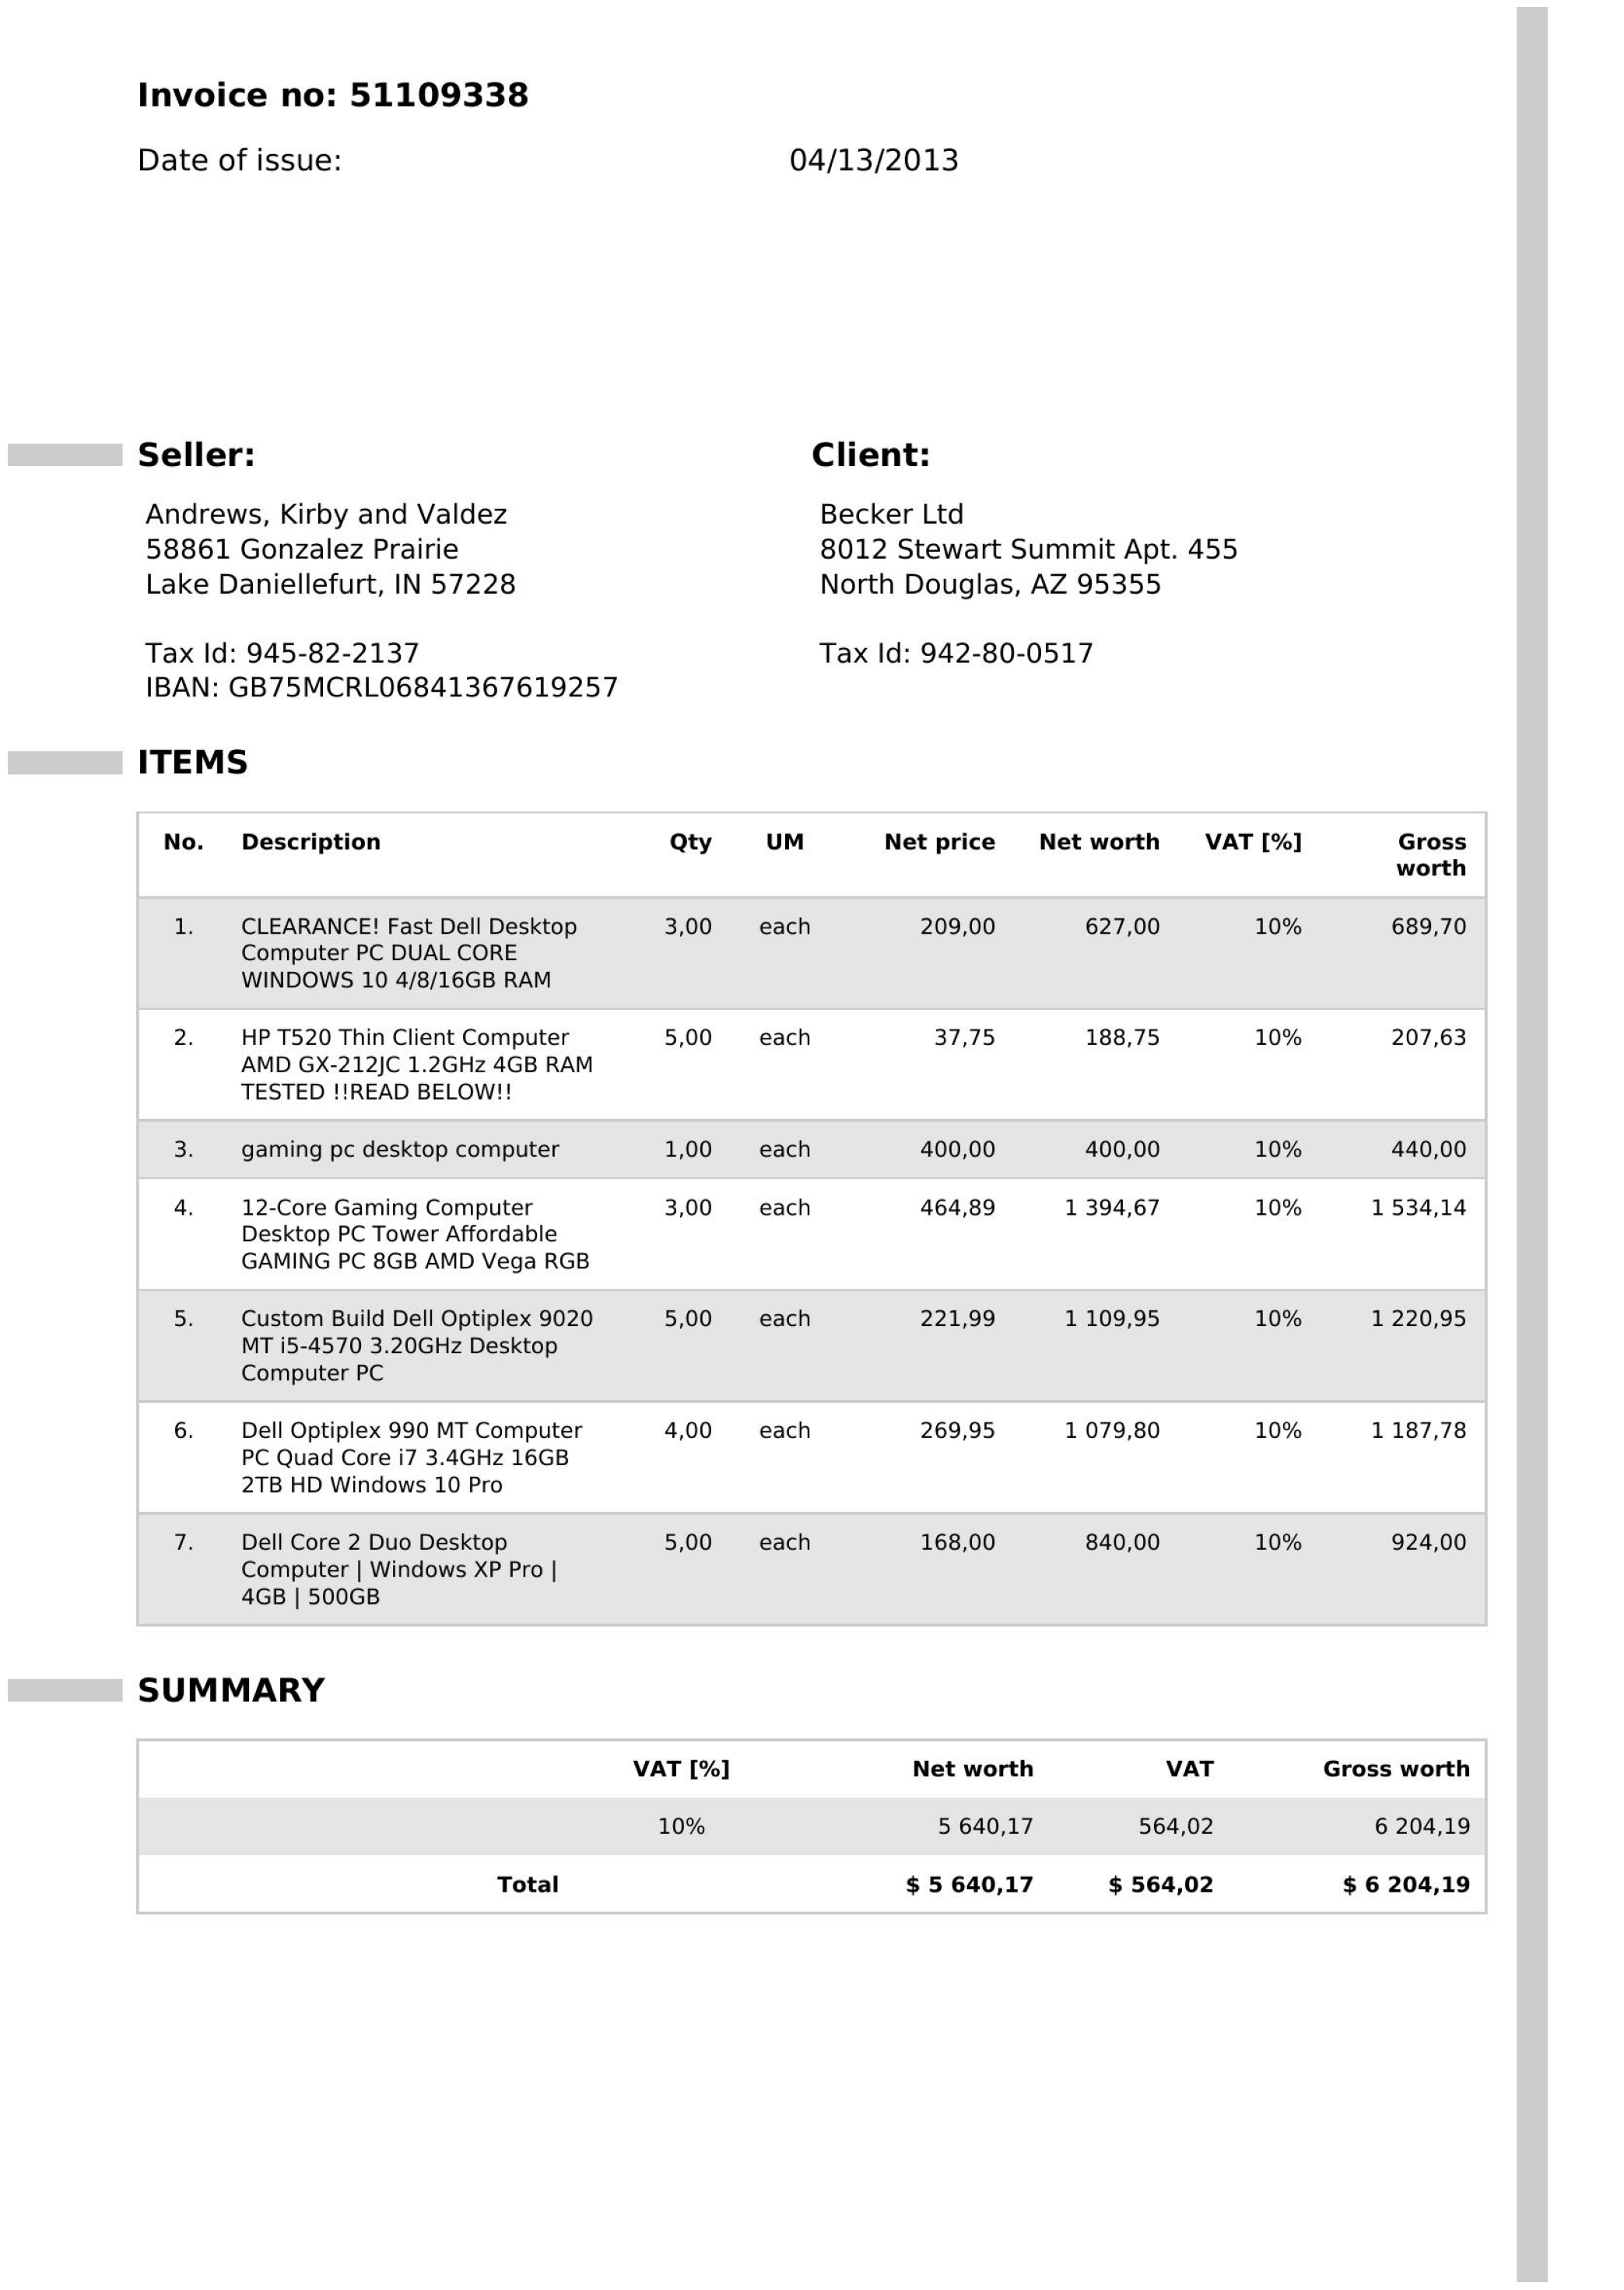

In [4]:
preview_img_path = os.path.join('data', 'batch_1', 'batch1_1','batch1-0001.jpg')
display_path(preview_img_path)

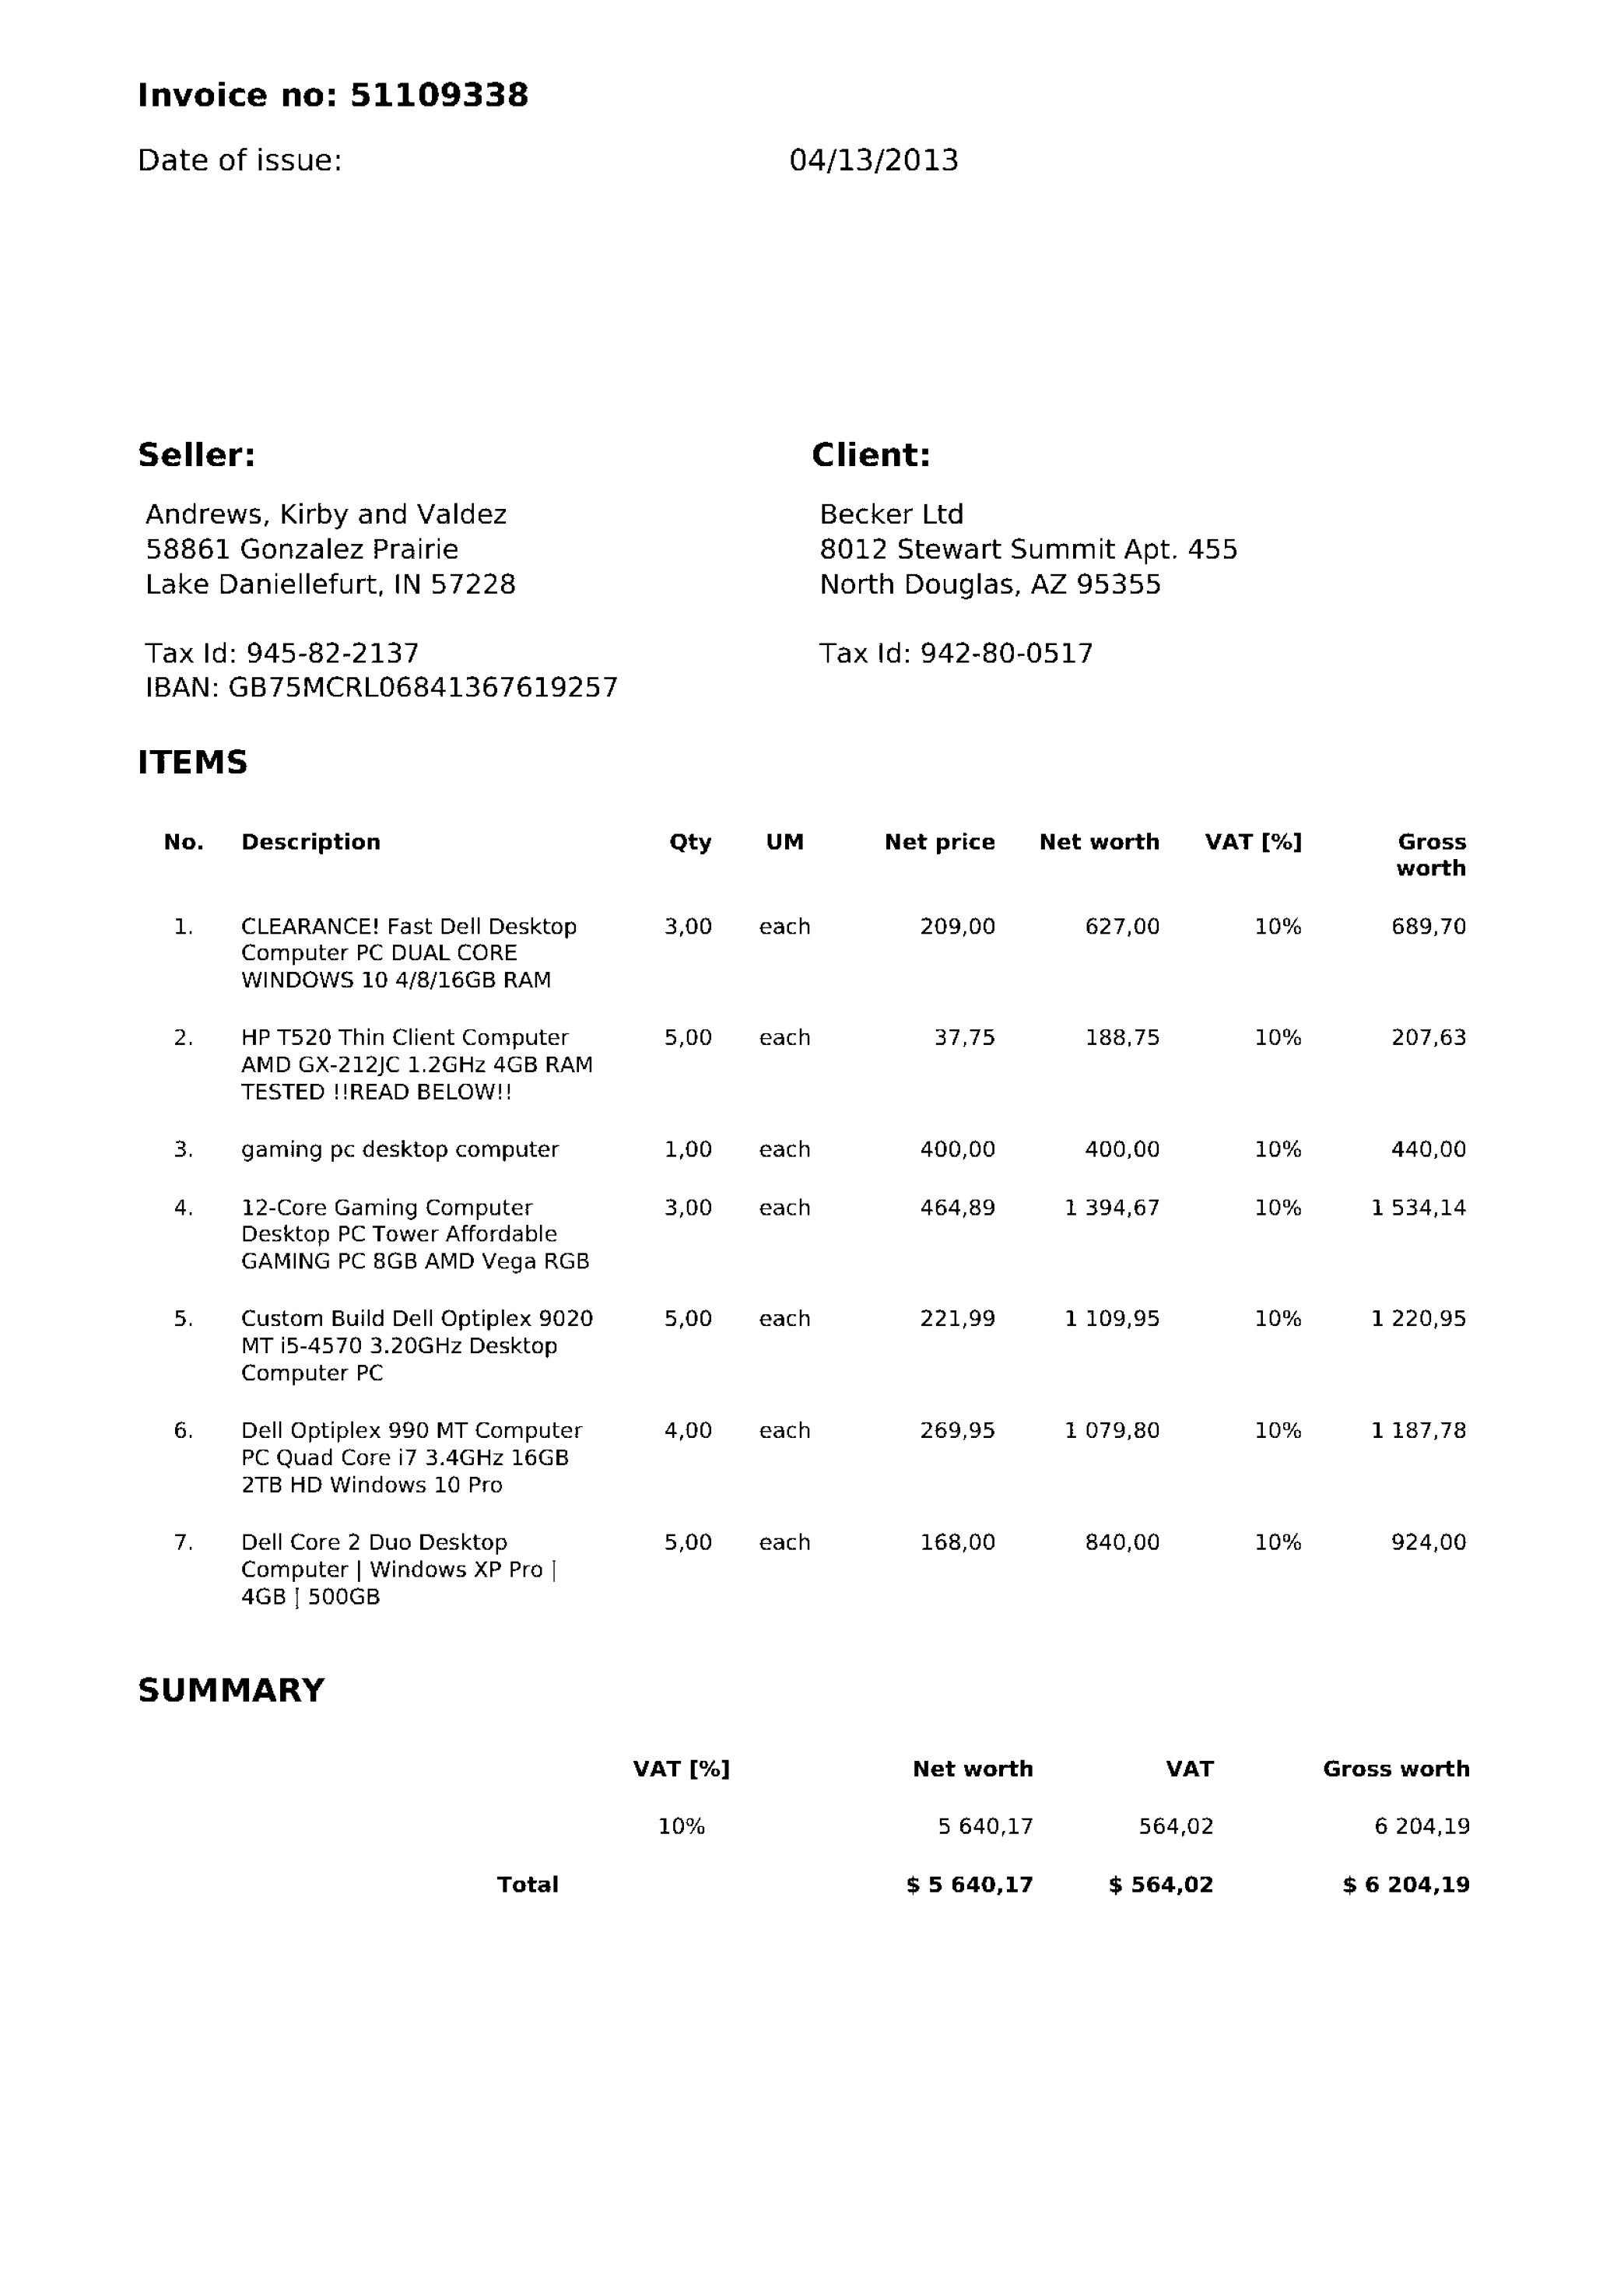

In [5]:
# Turn image into grey with threshold 
image = cv2.imread(preview_img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh_simple = 127
ret, thresh_simple = cv2.threshold(gray, thresh_simple, 255, cv2.THRESH_BINARY)
display(thresh_simple)

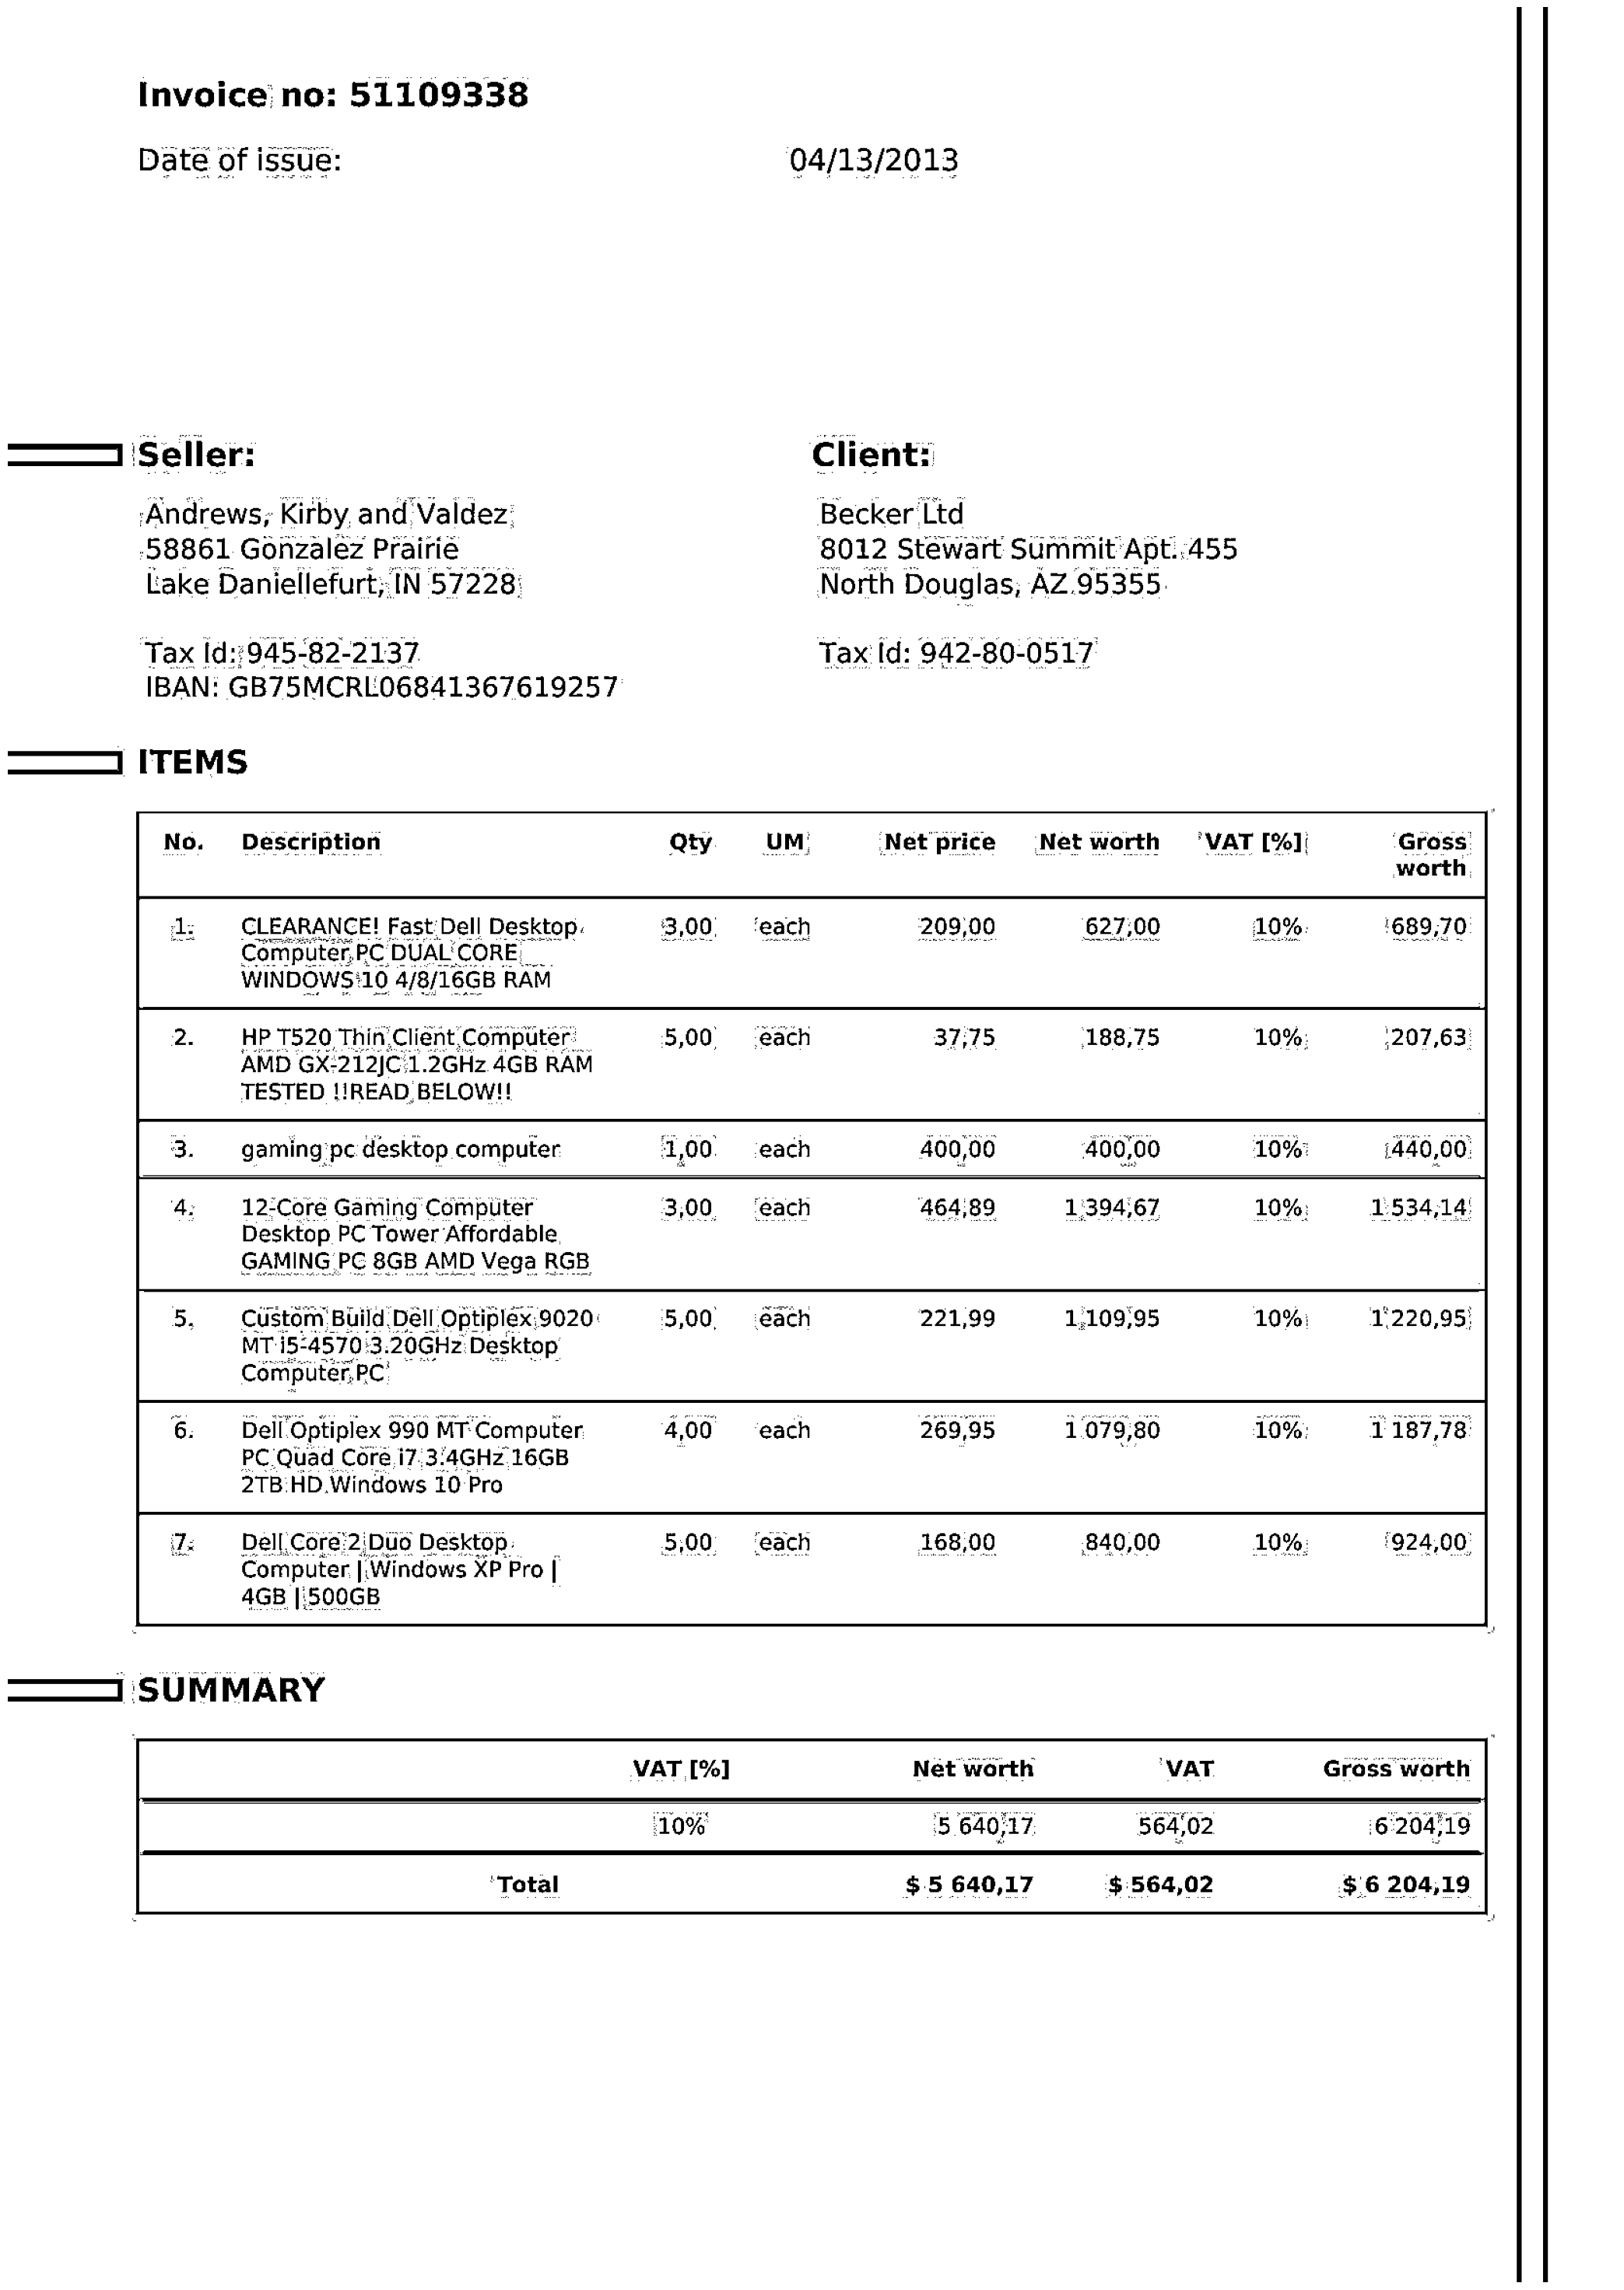

In [6]:
#adaptive thresholding
thresh_adaptive = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY, 11, 2
)
display(thresh_adaptive)

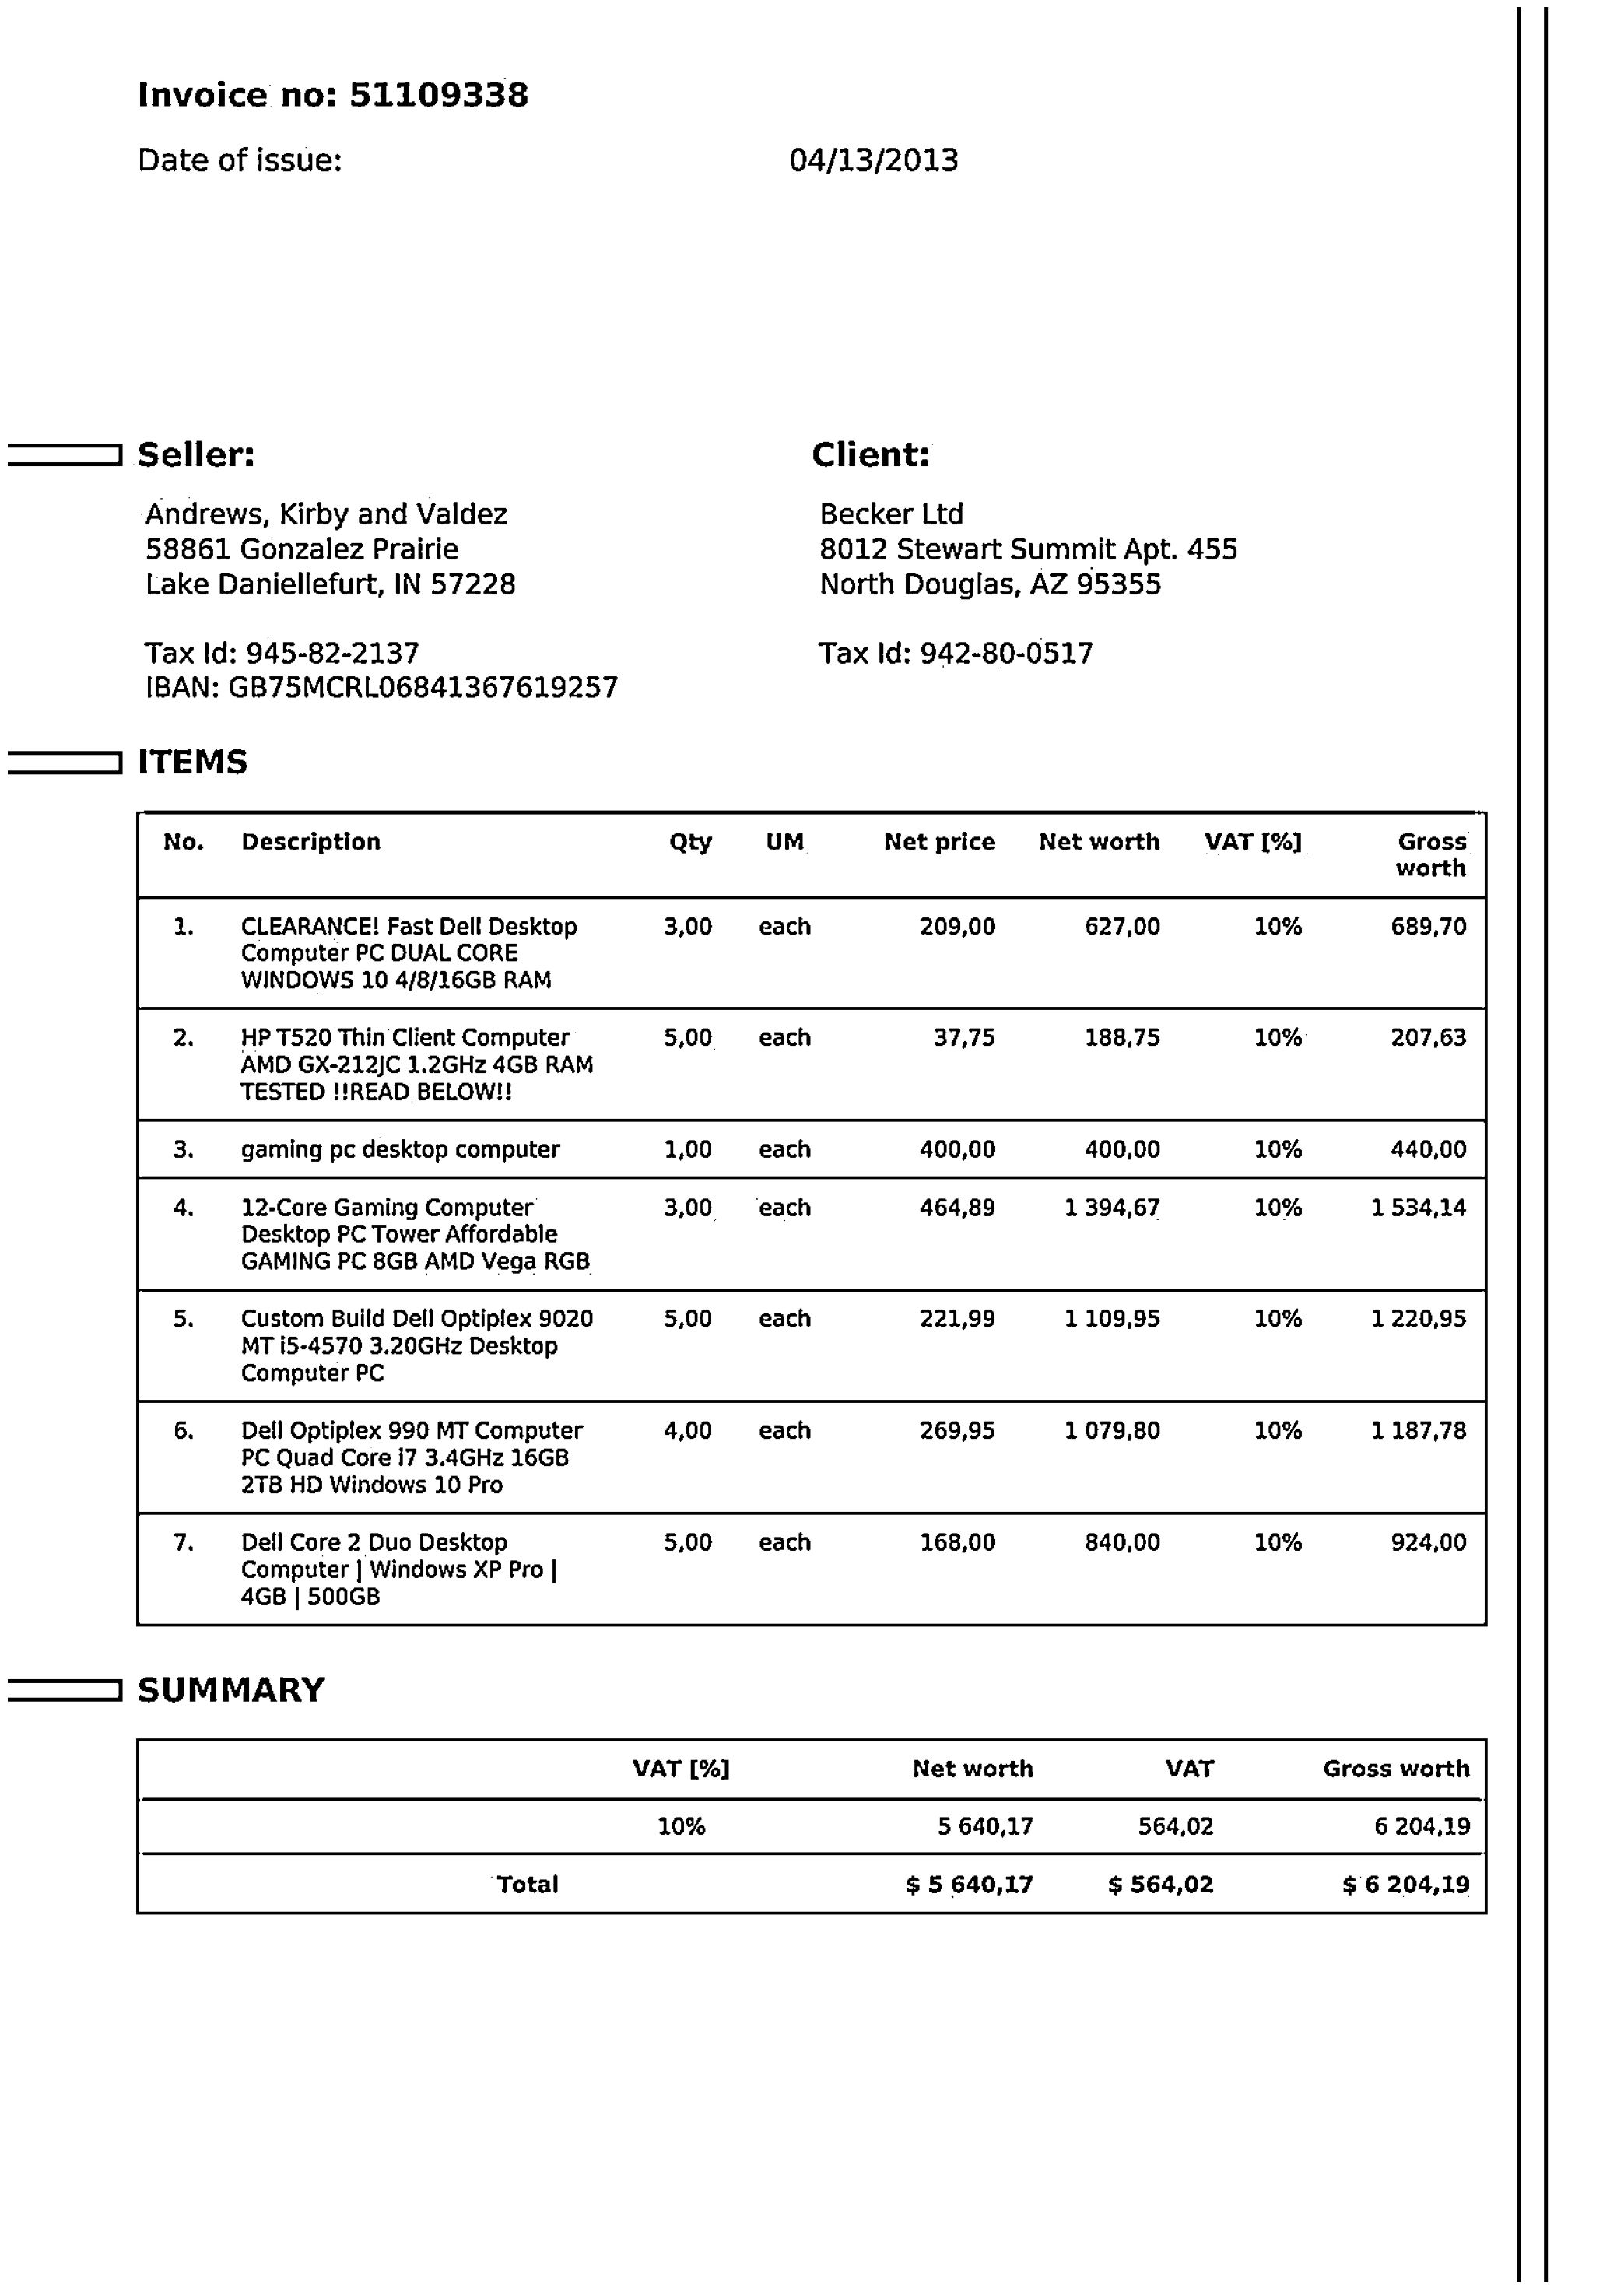

In [7]:
#Blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# 2. Aplicar el umbral adaptativo sobre la imagen ya desenfocada
thresh_final = cv2.adaptiveThreshold(
    blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 11, 2
)

display(thresh_final)

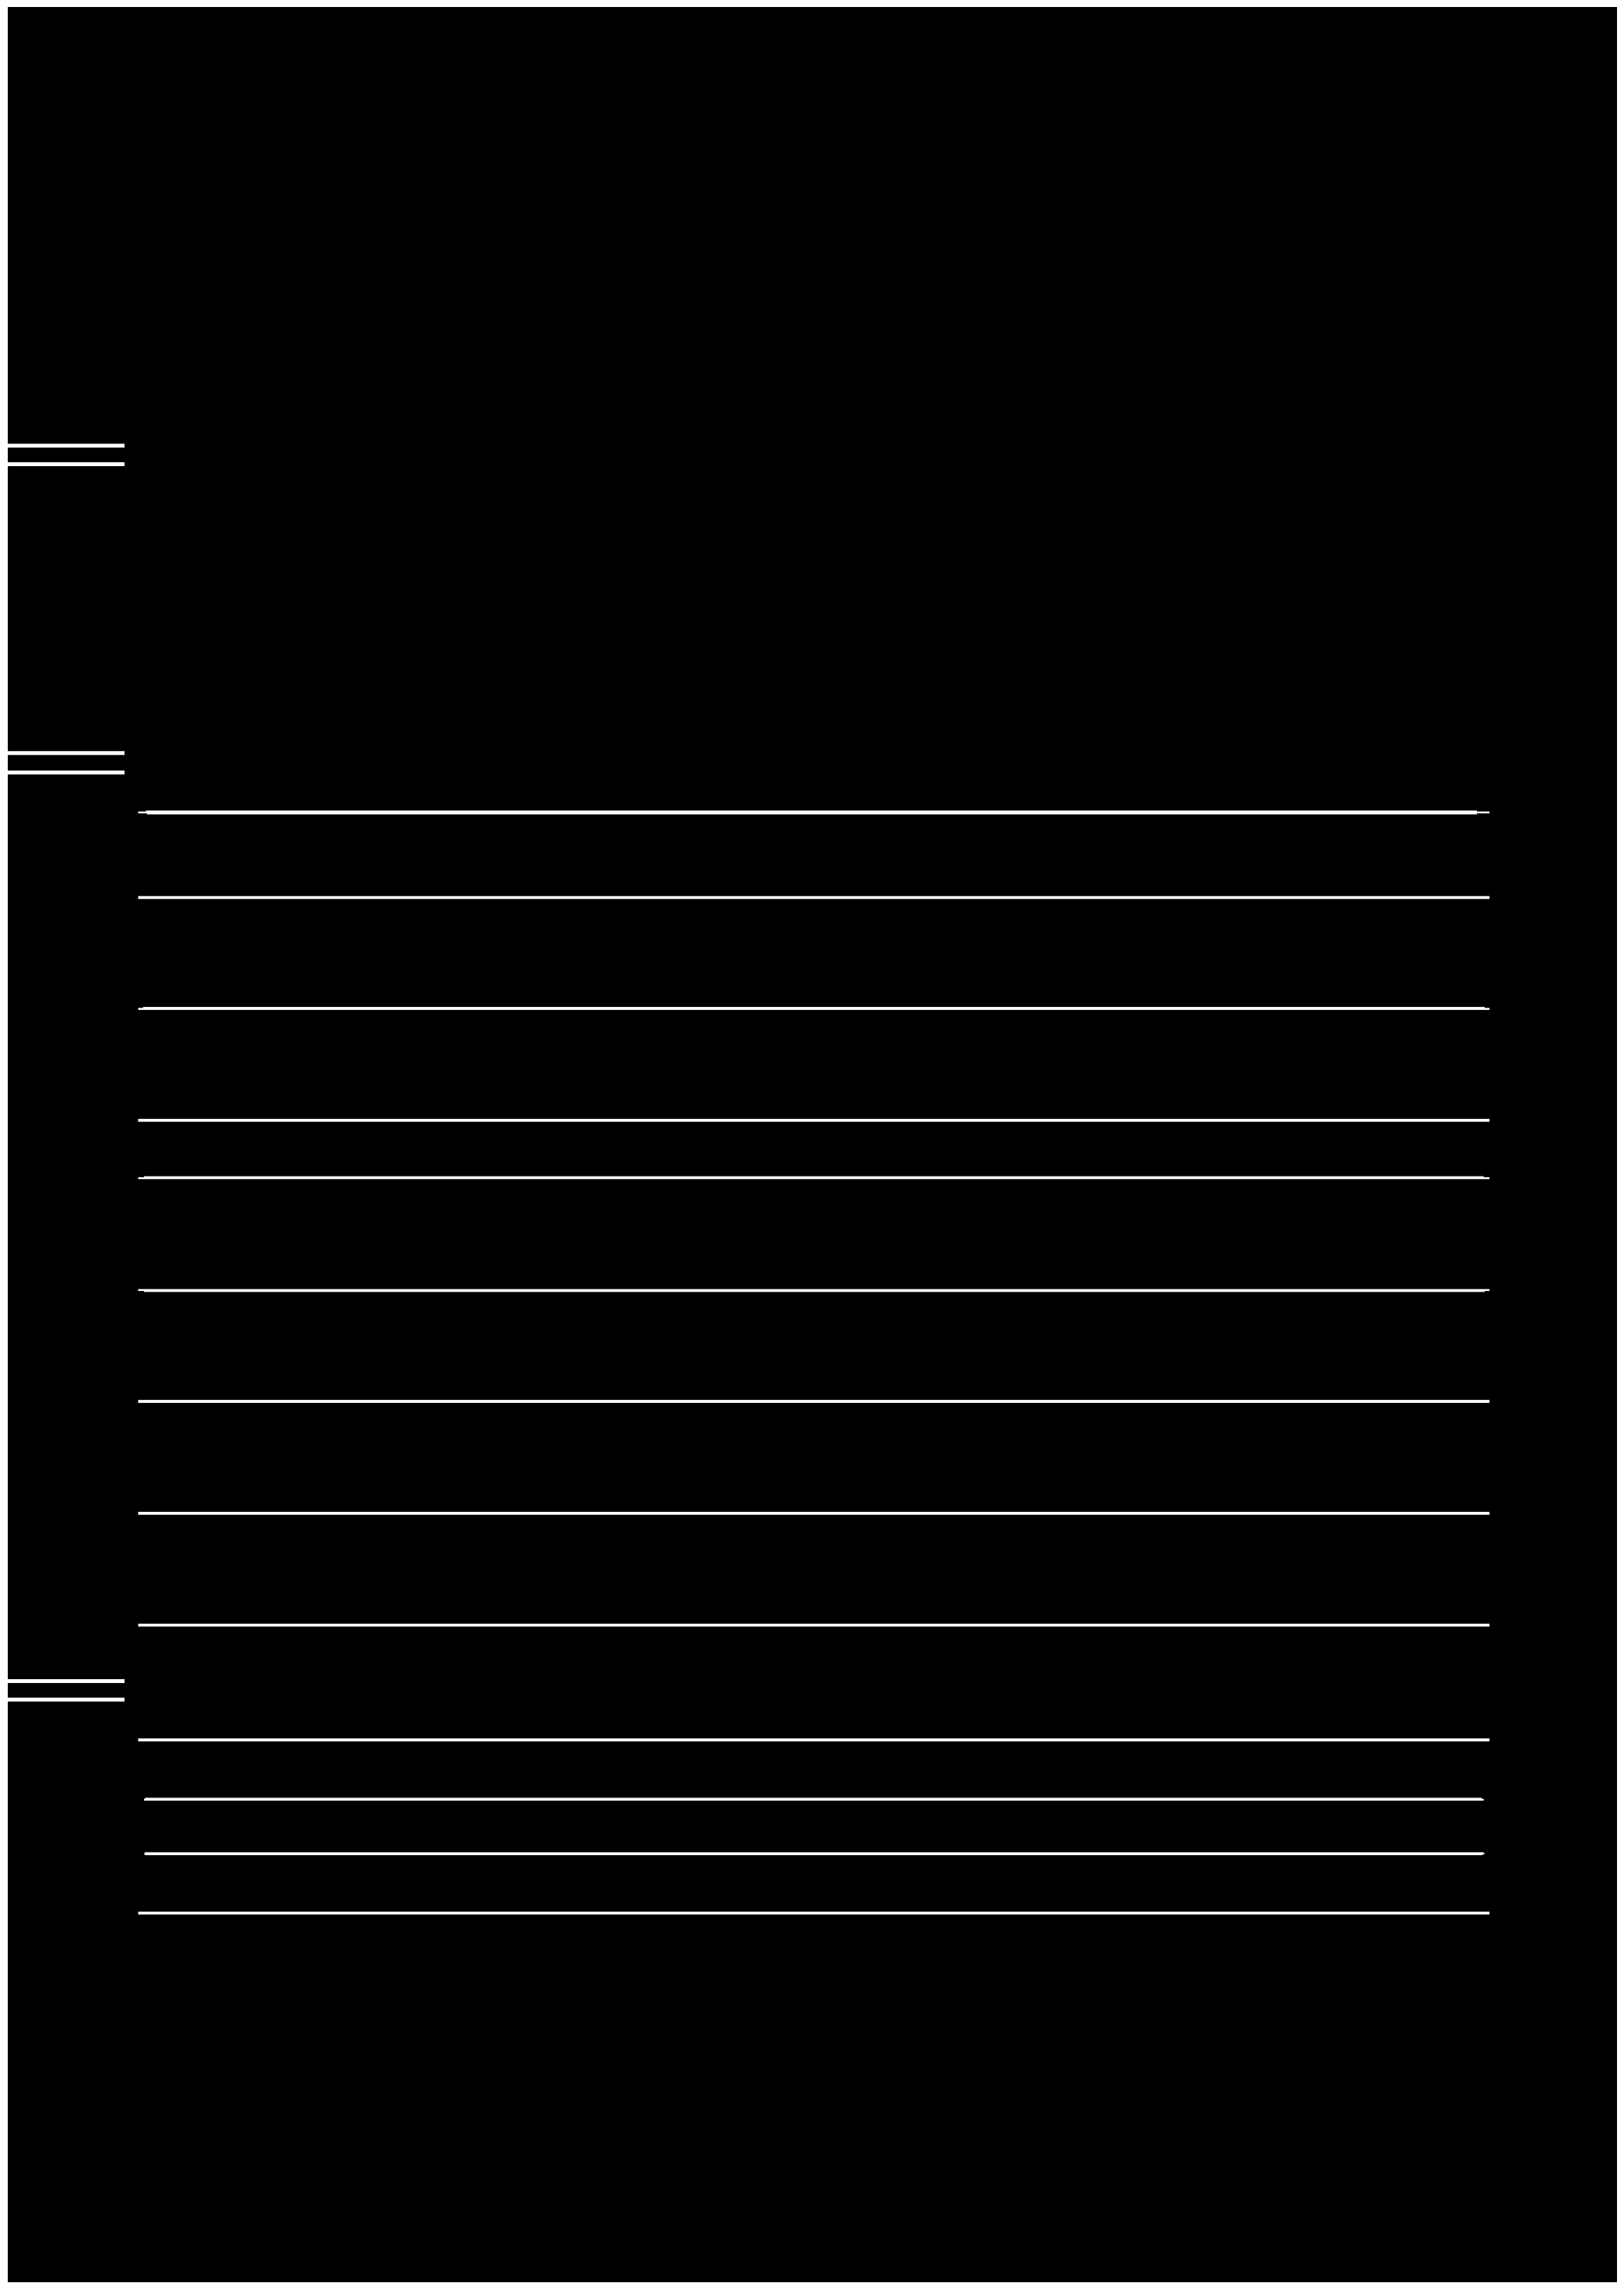

In [8]:
thresh_inv = cv2.bitwise_not(thresh_final)

# Take out lines on the image
horizontal_size = 30
vertical_size = 15

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))

# Detector de líneas verticales (1x50)
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))

detect_horizontal = cv2.morphologyEx(thresh_inv, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

display(detect_horizontal)

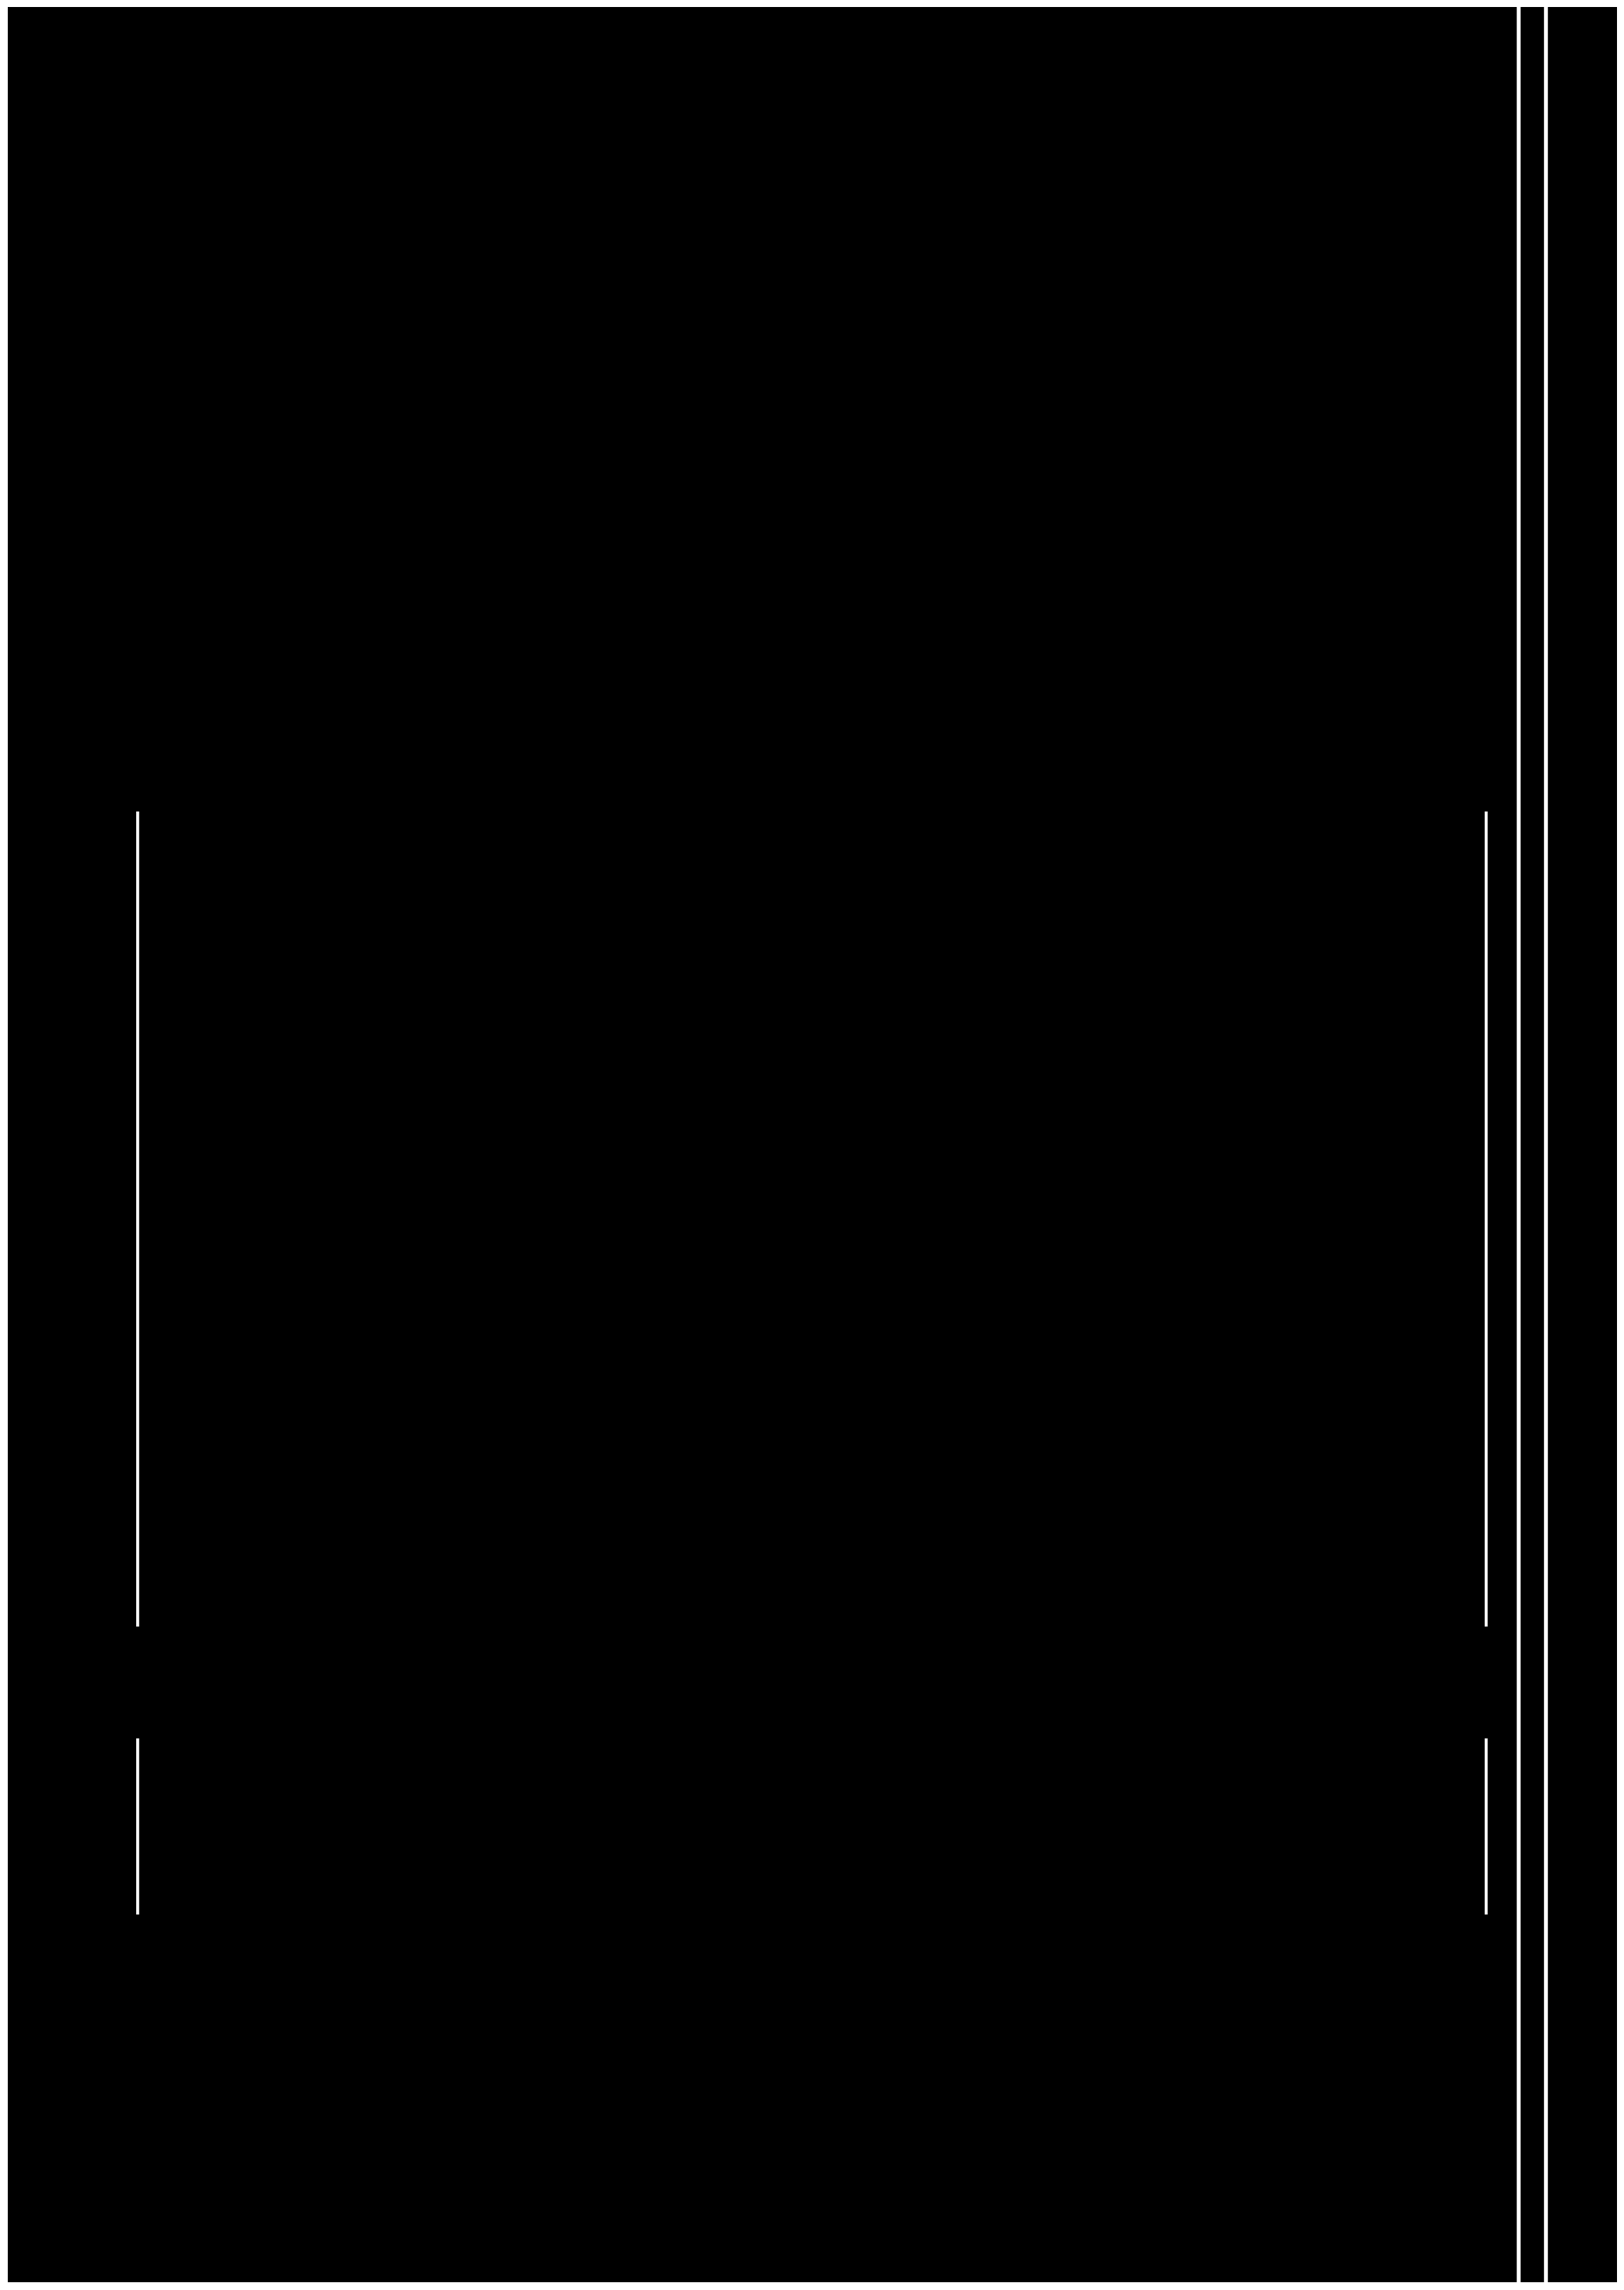

In [9]:
detect_vertical = cv2.morphologyEx(thresh_inv, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
display(detect_vertical)

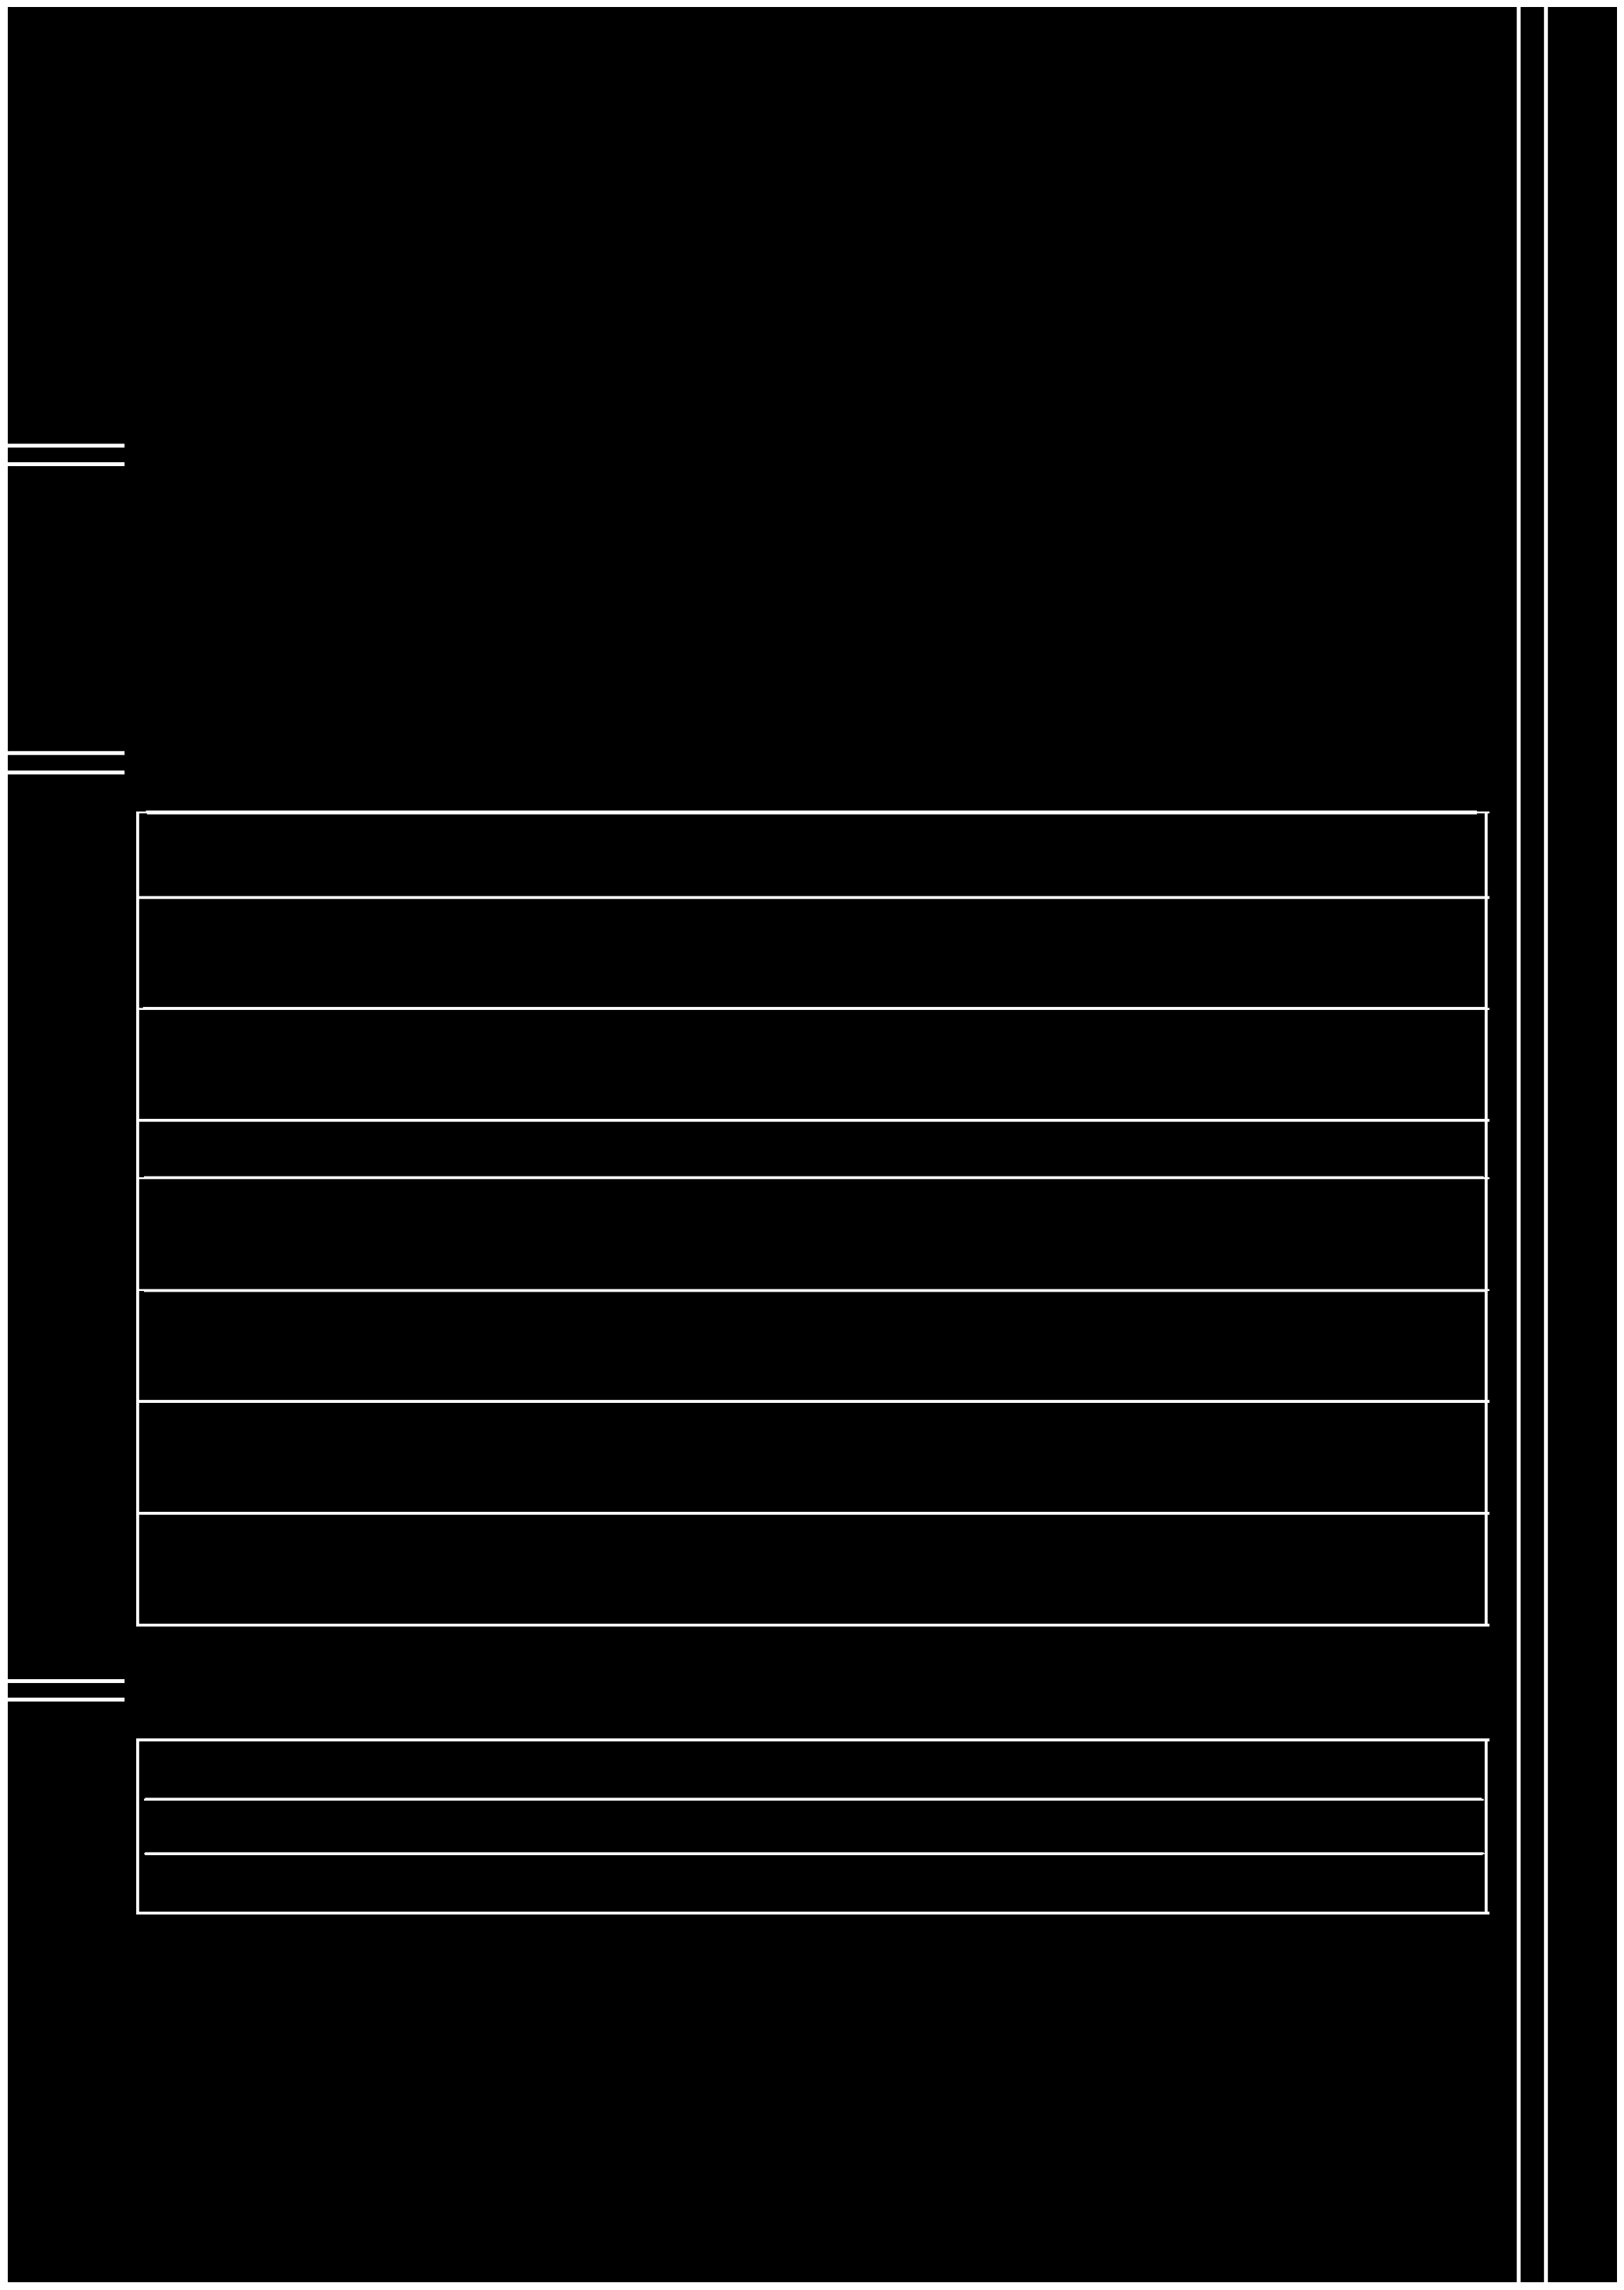

In [10]:
# Sum the two masks to get the full mask of lines in the image
mask_lines = cv2.add(detect_horizontal, detect_vertical)
display(mask_lines)

Resultado de la resta:


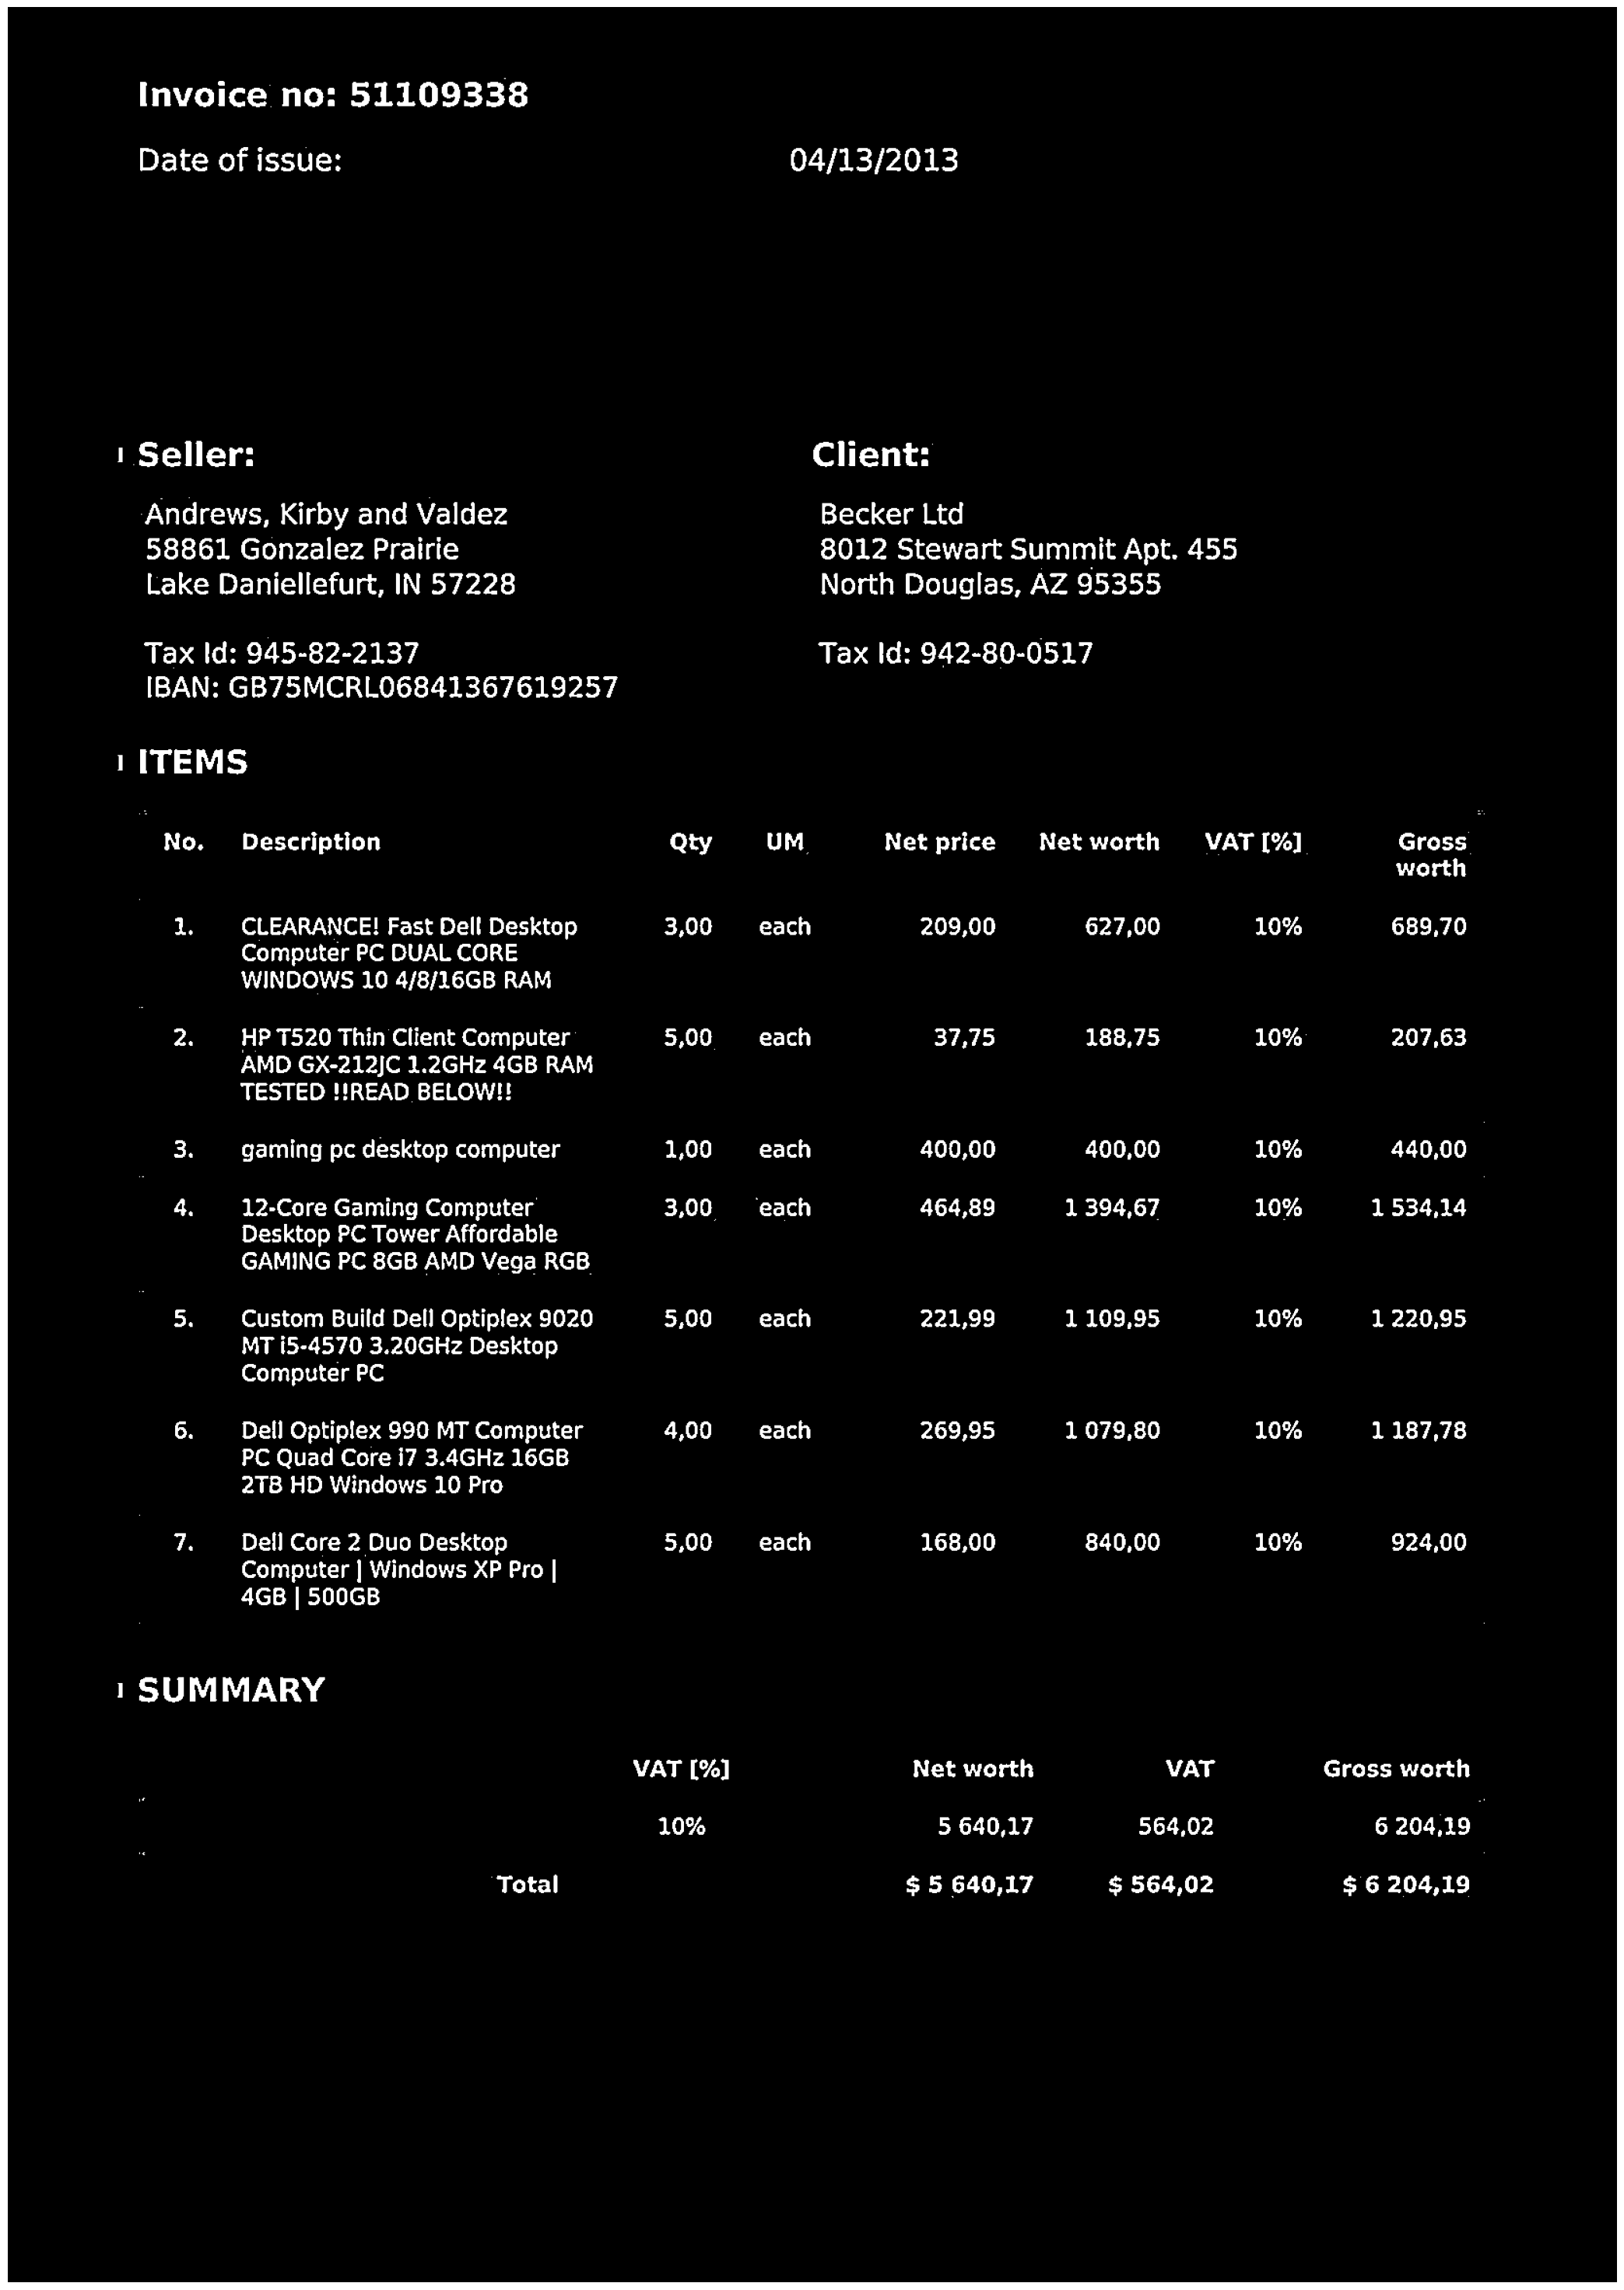

In [11]:
img_text_only = cv2.subtract(thresh_inv, mask_lines)

print("Resultado de la resta:")
display(img_text_only)

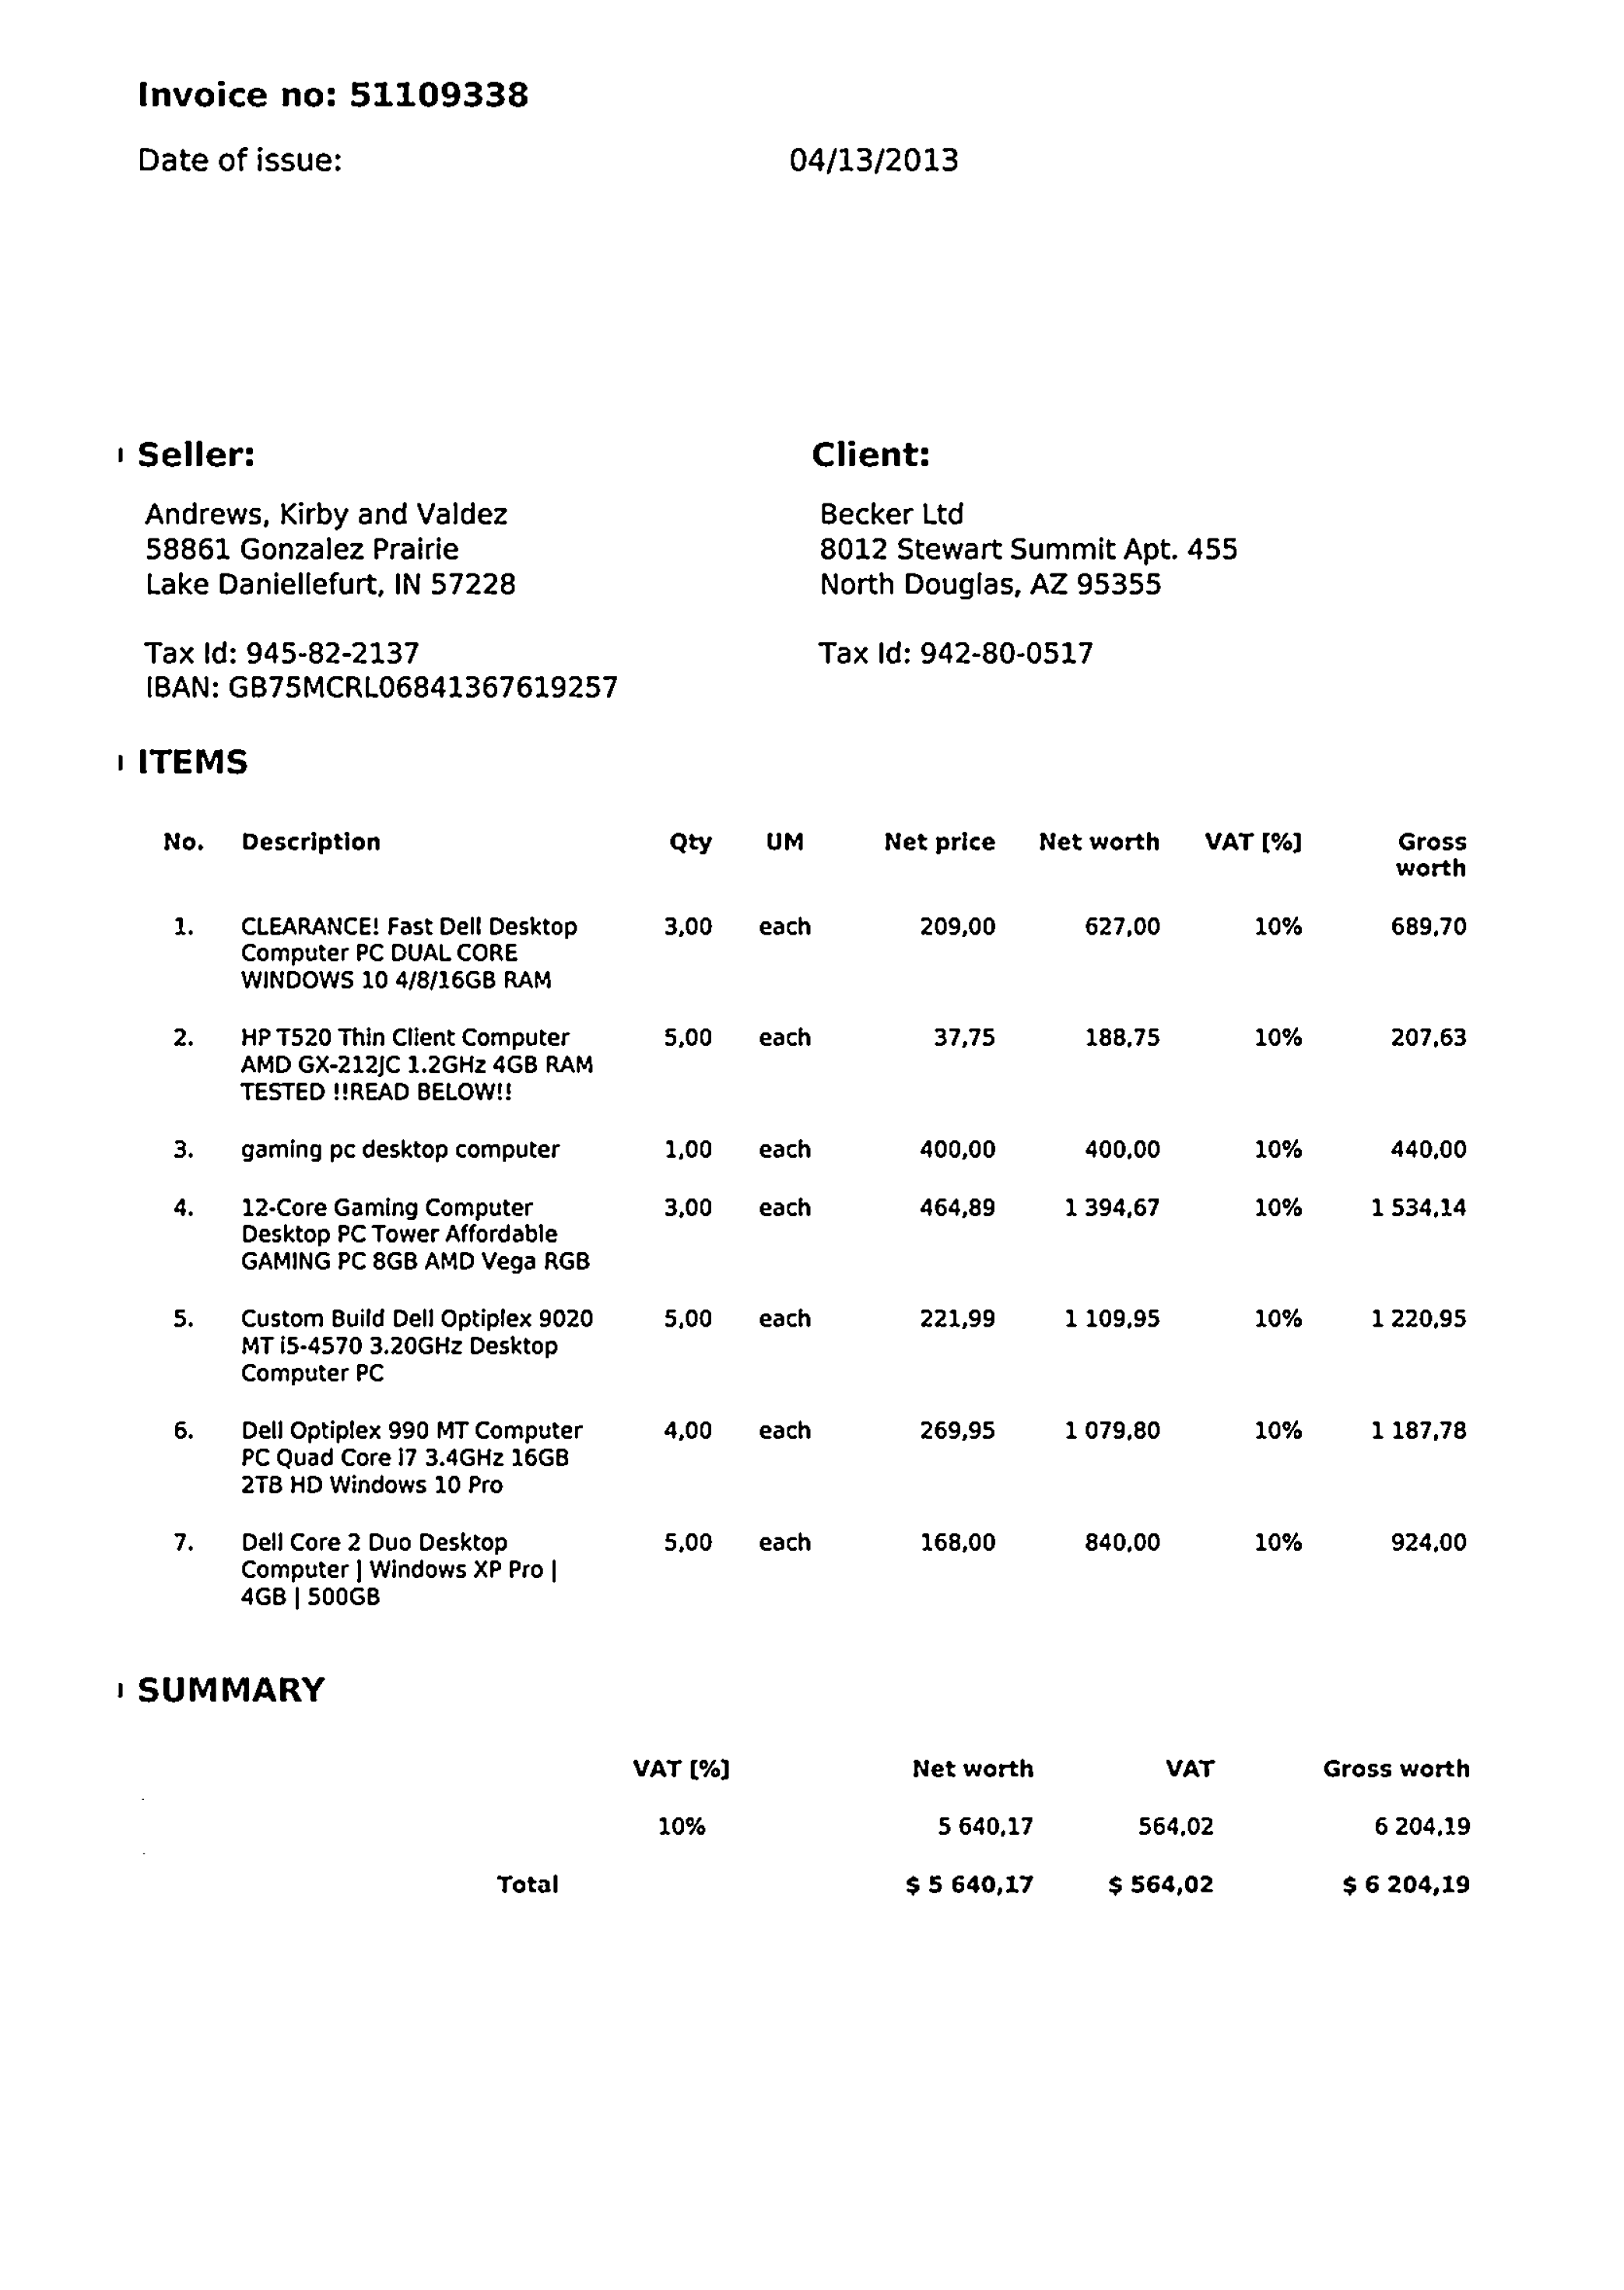

In [12]:
# inv again to get the text in white
img_text_only_inv = cv2.bitwise_not(img_text_only)
img_text_only_inv = cv2.medianBlur(img_text_only_inv, 3)
display(img_text_only_inv)


# OCR with tesseract and PaddleOCR

In [13]:
#Use the configuration  
custom_config = r'--oem 3 --psm 3'

# Image to text with Tesseract
texto_final = pytesseract.image_to_string(img_text_only_inv, config=custom_config, lang='eng')

print("--- RESULTADO FINAL DEL OCR ---")
print(texto_final)

--- RESULTADO FINAL DEL OCR ---
Invoice no: 51109338

Date of issue: 04/13/2013
' Seller: Client:
Andrews, Kirby and Valdez Becker Ltd
58861 Gonzalez Prairie 8012 Stewart Summit Apt. 455
Lake Daniellefurt, IN 57228 North Douglas, AZ 95355
Tax Id: 945-82-2137 Tax Id: 942-80-0517
IBAN: GB75MCRLO6841367619257
1 ITEMS
No. Description qty UM Net price Net worth VAT [%] Gross
worth
1, CLEARANCE! Fast Dell Desktop 3,00 each 209,00 627,00 10% 689,70
Computer PC DUAL CORE
WINDOWS 10 4/8/16GB RAM
2. HP 7520 Thin Client Computer 5,00 each 37,75 188,75 10% 207,63
AMD GX-212JC 1.2GHz 4GB RAM
TESTED !!READ BELOW!!
3. gaming pc desktop computer 1,00 each 400,00 400,00 10% 440,00
4. 12-Core Gaming Computer 3,00 each 464,89 1 394,67 10% 1534,14
Desktop PC Tower Affordable
GAMING PC 8GB AMD Vega RGB
5. Custom Build Dell Optiplex 9020 5,00 each 221,99 1 109,95 10% 1 220,95
MT 15-4570 3.20GHz Desktop
Computer PC
6. Dell Optiplex 990 MT Computer 4,00 each 269,95 1 079,80 10% 1 187,78
PC Quad Core J7 3.4GHz

In [14]:
from paddleocr import PaddleOCR
import cv2
ocr = PaddleOCR(lang="en", use_angle_cls=False)
img = image
H, W = img.shape[:2]
target_w = 1200
if W > target_w:
    s = target_w / W
    img = cv2.resize(img, (int(W*s), int(H*s)), interpolation=cv2.INTER_AREA)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
res = ocr.predict(rgb)


/Users/davidbazalduamendez/Documents/GitHub/invoices_ocr_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Checking connectivity to the model hosters, this may take a while. To bypass this check, set `PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK` to `True`.
/var/folders/bl/wz4tv3rs7vsd1fmkwrz2gnsc0000gn/T/ipykernel_87476/2066888871.py:3: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(lang="en", use_angle_cls=False)
/Users/davidbazalduamendez/Documents/GitHub/invoices_ocr_project/.venv/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:712: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download an

In [15]:
img_rgb = cv2.cvtColor(img_text_only_inv, cv2.COLOR_BGR2RGB)
#Resize image to a max width of 1200 pixels while maintaining aspect ratio
H, W = img_rgb.shape[:2]
target_w = 1200
if W > target_w:
    s = target_w / W
    img_rgb = cv2.resize(img_rgb, (int(W*s), int(H*s)), interpolation=cv2.INTER_AREA)

ocr = PaddleOCR(use_angle_cls=False, lang='en')

res = ocr.predict(img_rgb)

for idx in range(len(res)):
    res = res[idx]
    if res: # Check if there are any detected boxes
        for line in res:
            print(line)

/var/folders/bl/wz4tv3rs7vsd1fmkwrz2gnsc0000gn/T/ipykernel_87476/3606632588.py:9: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=False, lang='en')
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/davidbazalduamendez/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/davidbazalduamendez/.paddlex/official_models/UVDoc`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/davidbazalduamendez/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. U

input_path
page_index
doc_preprocessor_res
dt_polys
model_settings
text_det_params
text_type
text_rec_score_thresh
return_word_box
rec_texts
rec_scores
rec_polys
vis_fonts
textline_orientation_angles
rec_boxes


In [16]:
#Extract texts, boxes and confidence scores into separate lists
textos = res['rec_texts']
cajas = res['rec_boxes']
confianzas = res['rec_scores']

print(f"--- Se encontraron {len(textos)} textos ---\n")

for texto, caja, score in zip(textos, cajas, confianzas):
    
    if score > 0.80: 
        print(f"Text: {texto}")
        print(f"Trust: {score:.2f}")
        print(f"Coords: {caja}")
        print("-" * 20)

--- Se encontraron 105 textos ---

Text: Invoice no: 51109338
Trust: 0.98
Coords: [64 ... 58]
--------------------
Text: Date of issue:
Trust: 1.00
Coords: [ 62 ... 106]
--------------------
Text: 04/13/2013
Trust: 1.00
Coords: [606 ... 111]
--------------------
Text:  Seller:
Trust: 0.99
Coords: [ 37 ... 344]
--------------------
Text: Client:
Trust: 1.00
Coords: [614 ... 354]
--------------------
Text: Andrews, Kirby and Valdez
Trust: 0.99
Coords: [ 61 ... 395]
--------------------
Text: Becker Ltd
Trust: 0.99
Coords: [619 ... 400]
--------------------
Text: 58861 Gonzalez Prairie
Trust: 0.99
Coords: [ 61 ... 422]
--------------------
Text: 8012 Stewart Summit Apt. 455
Trust: 0.98
Coords: [619 ... 433]
--------------------
Text: Lake Daniellefurt, IN 57228
Trust: 0.99
Coords: [ 61 ... 452]
--------------------
Text: North Douglas, AZ 95355
Trust: 0.99
Coords: [618 ... 459]
--------------------
Text: Tax Id: 945-82-2137
Trust: 1.00
Coords: [ 56 ... 507]
--------------------
Text: Tax 

In [17]:
# --- CONFIGURATION ---
# Zone 1: Header (Top of the page)
Y_HEADER_LIMIT = 300  # Everything above Y=300 is considered Header

# Zone 2: Addresses (Middle of the page)
# Everything between Y=300 and Y=580
Y_ADDRESS_BOTTOM_LIMIT = 500

# Horizontal Divider for Seller/Client
X_DIVIDER = 400

# --- LISTS TO STORE RESULTS ---
header_data = []
seller_data = []
client_data = []

print(f"--- Processing extracted data ---\n")

# Iterate through the lists
for text, box, score in zip(textos, cajas, confianzas):
    
    if score > 0.80:
        
        # Get coordinates (Assuming flat list [x_min, y_min, x_max, y_max])
        x_pos = box[0]
        y_pos = box[1]
        
        # --- LOGIC START ---
        
        # ZONE 1: HEADER (Top)
        if y_pos < Y_HEADER_LIMIT:
            header_data.append(text)
            
        # ZONE 2: ADDRESSES (Middle)
        elif y_pos < Y_ADDRESS_BOTTOM_LIMIT:
            
            # Split Left vs Right
            if x_pos < X_DIVIDER:
                seller_data.append(text)
            else:
                client_data.append(text)
                
        # (Zone 3: Items - We are ignoring them for now)

# --- PRINT FINAL RESULTS ---
print("HEADER INFO:")
for line in header_data:
    print(f"  - {line}")

print("\nSELLER DATA:")
for line in seller_data:
    print(f"  - {line}")

print("\nCLIENT DATA:")
for line in client_data:
    print(f"  - {line}")

--- Processing extracted data ---

HEADER INFO:
  - Invoice no: 51109338
  - Date of issue:
  - 04/13/2013

SELLER DATA:
  -  Seller:
  - Andrews, Kirby and Valdez
  - 58861 Gonzalez Prairie
  - Lake Daniellefurt, IN 57228
  - Tax Id: 945-82-2137

CLIENT DATA:
  - Client:
  - Becker Ltd
  - 8012 Stewart Summit Apt. 455
  - North Douglas, AZ 95355
  - Tax Id: 942-80-0517


In [18]:
# --- CONFIGURATION ---
Y_ITEMS_TOP = 590      # Start just below the headers/addresses
Y_ITEMS_BOTTOM = 1300  #

items_raw = []

print(f"--- EXTRACTING ITEMS (Raw) ---\n")

for text, box, score in zip(textos, cajas, confianzas):
    
    if score > 0.60: # Lower confidence slightly for numbers/symbols
        
        y_pos = box[1] # Top-left Y
        
        # Filter: Only take things inside the "Table Zone"
        if Y_ITEMS_TOP < y_pos < Y_ITEMS_BOTTOM:
            items_raw.append((box, text)) # We keep the box to sort later!

# Sort the found items by their Y position (Top to Bottom)
# This helps us read line by line.
items_raw.sort(key=lambda x: x[0][1])

for box, text in items_raw:
    print(f"Y={int(box[1])} | {text}")

--- EXTRACTING ITEMS (Raw) ---

Y=631 | No.
Y=632 | Description
Y=637 | Qty
Y=641 | UM
Y=641 | Net price
Y=643 | Net worth
Y=645 | Gross
Y=646 | VAT [%]
Y=664 | worth
Y=701 | 1.
Y=701 | CLEARANCE! Fast Dell Desktop
Y=706 | 3,00
Y=709 | each
Y=709 | 209,00
Y=712 | 689,70
Y=715 | 627,00
Y=715 | 10%
Y=723 | Computer PC DUAL CORE
Y=744 | WINDOWS 10 4/8/16GB RAM
Y=789 | 2.
Y=791 | HP T520 Thin Client Computer
Y=798 | 5,00
Y=800 | each
Y=801 | 37,75
Y=803 | 188.75
Y=804 | 10%
Y=805 | 207,63
Y=813 | AMD GX-212JC 1.2GHz 4GB RAM
Y=837 | TESTED !!READ BELOW!!
Y=881 | 3.
Y=884 | gaming pc desktop computer
Y=889 | 1,00
Y=891 | each
Y=892 | 400,00
Y=893 | 400,00
Y=894 | 10%
Y=896 | 440,00
Y=924 | 4.
Y=930 | 12-Core Gaming Computer
Y=936 | 3,00
Y=938 | each
Y=938 | 464,89
Y=941 | 1 394,67
Y=941 | 10%
Y=944 | 1 534,14
Y=951 | Desktop PC Tower Affordable
Y=973 | GAMING PC 8GB AMD Vega RGB
Y=1019 | 5.
Y=1020 | Custom Build Dell Optiplex 9020
Y=1026 | 5,00
Y=1028 | each
Y=1028 | 221,99
Y=1029 | 1 109,95

In [19]:
# --- CONFIGURATION ---
Y_TABLE_DATA_START = 680 

# --- HORIZONTAL LIMITS ---
X_LIMIT_NO = 70         # Index < 70
X_LIMIT_DESC = 440      # Description: 70 to 440
X_LIMIT_QTY = 520       # Qty: 440 to 520
X_LIMIT_UM = 600        # UM: 520 to 600
X_LIMIT_PRICE = 750     # Net Price: 600 to 750
X_LIMIT_NET = 900       # Net Worth: 750 to 900
X_LIMIT_VAT = 1000      # VAT %: 900 to 1000
# Gross Worth is anything > 1000

structured_items = []
current_row = {}

print(f"--- EXTRACTING ALL TABLE COLUMNS ---\n")

for box, text in items_raw:
    
    # Coords [x_min, y_min, x_max, y_max]
    x_pos = box[0]
    y_pos = box[1]
    
    if y_pos < Y_TABLE_DATA_START:
        continue

    # 1. DETECT NEW ROW (Index)
    if x_pos < X_LIMIT_NO and text.replace('.', '').isdigit():
        
        if current_row:
            structured_items.append(current_row)
        
        # Initialize dictionary with ALL fields
        current_row = {
            "index": text,
            "description": "",
            "qty": "",
            "um": "",
            "net_price": "",
            "net_worth": "",
            "vat_percent": "",
            "gross_worth": ""
        }
    
    # 2. FILL COLUMNS
    elif current_row:
        
        # DESCRIPTION
        if X_LIMIT_NO < x_pos < X_LIMIT_DESC:
            if current_row["description"]:
                current_row["description"] += " " + text
            else:
                current_row["description"] = text
                
        # QTY
        elif X_LIMIT_DESC < x_pos < X_LIMIT_QTY:
            current_row["qty"] = text

        # UNIT OF MEASURE (UM)
        elif X_LIMIT_QTY < x_pos < X_LIMIT_UM:
            current_row["um"] = text

        # NET PRICE
        elif X_LIMIT_UM < x_pos < X_LIMIT_PRICE:
            current_row["net_price"] = text

        # NET WORTH
        elif X_LIMIT_PRICE < x_pos < X_LIMIT_NET:
            current_row["net_worth"] = text

        # VAT %
        elif X_LIMIT_NET < x_pos < X_LIMIT_VAT:
            current_row["vat_percent"] = text
            
        # GROSS WORTH (The final column)
        elif x_pos > X_LIMIT_VAT:
            current_row["gross_worth"] = text

# Don't forget the last row!
if current_row:
    structured_items.append(current_row)

# --- DISPLAY RESULTS ---
for item in structured_items:
    print(f"   Item {item.get('index')}")
    print(f"   Desc:  {item.get('description')}")
    print(f"   Qty:   {item.get('qty')} {item.get('um')}")
    print(f"   Price: {item.get('net_price')} | Net: {item.get('net_worth')}")
    print(f"   VAT:   {item.get('vat_percent')} | Gross: {item.get('gross_worth')}")
    print("-" * 30)

--- EXTRACTING ALL TABLE COLUMNS ---

   Item 1.
   Desc:  CLEARANCE! Fast Dell Desktop Computer PC DUAL CORE WINDOWS 10 4/8/16GB RAM
   Qty:   3,00 each
   Price: 209,00 | Net: 627,00
   VAT:   10% | Gross: 689,70
------------------------------
   Item 2.
   Desc:  HP T520 Thin Client Computer AMD GX-212JC 1.2GHz 4GB RAM TESTED !!READ BELOW!!
   Qty:   5,00 each
   Price: 37,75 | Net: 188.75
   VAT:   10% | Gross: 207,63
------------------------------
   Item 3.
   Desc:  gaming pc desktop computer
   Qty:   1,00 each
   Price: 400,00 | Net: 400,00
   VAT:   10% | Gross: 440,00
------------------------------
   Item 4.
   Desc:  12-Core Gaming Computer Desktop PC Tower Affordable GAMING PC 8GB AMD Vega RGB
   Qty:   3,00 each
   Price: 464,89 | Net: 1 394,67
   VAT:   10% | Gross: 1 534,14
------------------------------
   Item 5.
   Desc:  Custom Build Dell Optiplex 9020 MT i5-4570 3.20GHz Desktop Computer PC
   Qty:   5,00 each
   Price: 221,99 | Net: 1 109,95
   VAT:   10% | Gross:

In [20]:
# --- CONFIGURATION ---
Y_SUMMARY_START = 1300 

summary_data = []

print(f"--- EXTRACTING SUMMARY SECTION ---\n")

for text, box, score in zip(textos, cajas, confianzas):
    
    if score > 0.80:
        
        # Coords [x_min, y_min, x_max, y_max]
        x_pos = box[0]
        y_pos = box[1]
        
        # FILTER: Only take things at the bottom of the page
        if y_pos > Y_SUMMARY_START:
            # We store the Y position to sort them later
            summary_data.append((y_pos, x_pos, text))

# Sort by Y (vertical order), then by X (left to right)
summary_data.sort(key=lambda k: (k[0], k[1]))

# --- DISPLAY RESULTS ---
print("RAW SUMMARY DATA:")
for item in summary_data:
    # item structure is (y, x, text)
    print(f"Y={int(item[0])} | X={int(item[1])} | {item[2]}")

--- EXTRACTING SUMMARY SECTION ---

RAW SUMMARY DATA:
Y=1315 | X=6 | SUMMARY
Y=1379 | X=1001 | Gross worth
Y=1381 | X=658 | Net worth
Y=1381 | X=869 | VAT
Y=1385 | X=426 | VAT [%]
Y=1422 | X=1039 | 6 204,19
Y=1426 | X=679 | 5 640,17
Y=1427 | X=847 | 564.02
Y=1431 | X=447 | 10%
Y=1468 | X=1013 | $ 6 204,19
Y=1472 | X=651 | $ 5 640,17
Y=1473 | X=822 | $ 564,02
Y=1476 | X=311 | Total


In [21]:
# --- config ---
Y_TOTAL_ROW_START = 1450


summary_structured = {
    "net_worth": None,
    "vat_amount": None,
    "gross_total": None
}

for item in summary_data:
    y_pos = item[0]
    x_pos = item[1]
    texto = item[2]
    
    if y_pos > Y_TOTAL_ROW_START:
        
        
        # NET WORTH 
        if 600 < x_pos < 750:
            summary_structured["net_worth"] = texto
            
        # VAT AMOUNT 
        elif 800 < x_pos < 900:
            summary_structured["vat_amount"] = texto
            
        # GROSS TOTAL 
        elif x_pos > 950:
            summary_structured["gross_total"] = texto

# --- Show Results ---
print("  SUMMARY of INVOICE:")
print(f"  Net Worth:   {summary_structured['net_worth']}")
print(f"  VAT Amount:  {summary_structured['vat_amount']}")
print(f"  Gross Total: {summary_structured['gross_total']}")

  SUMMARY of INVOICE:
  Net Worth:   $ 5 640,17
  VAT Amount:  $ 564,02
  Gross Total: $ 6 204,19


# Data Cleaning and NLP

In [22]:
import re

print("--- REGEX CLEANING ---")

# Our master pattern: space + [I or ]] + space
pattern = r'\s[I\]]\s'

for item in structured_items:
    original_desc = item['description']
    
    # Check if we find the error to show the "Before" state
    if re.search(pattern, original_desc):
        print(f" Dirty:  {original_desc}")
        
        # --- THE MAGIC HAPPENS HERE ---
        # Replace the pattern with the correct pipe " | "
        clean_desc = re.sub(pattern, " | ", original_desc)
        
        # Save the clean data back to the dictionary
        item['description'] = clean_desc
        
        print(f" Clean: {clean_desc}")
        print("-" * 30)


--- REGEX CLEANING ---
 Dirty:  Computer ] Windows XP Pro I 4GB | 500GB
 Clean: Computer | Windows XP Pro | 4GB | 500GB
------------------------------


In [23]:
import torch
from transformers import pipeline

# --- 1. SETUP MODELS ---
# We check if GPU is available (MPS for Mac, CUDA for Nvidia), else CPU
device = 0 if torch.cuda.is_available() or torch.backends.mps.is_available() else -1
print(f"Hardware Accelerator: {'GPU/MPS' if device == 0 else 'CPU'}")

print("Loading Address Model (RoBERTa QA)...")
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2", device=device)

print("Loading Classification Model (BART Zero-Shot)...")
# BART-Large is heavy but THE BEST for accuracy.
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)
print("Models Ready!")

# --- 2. ADDRESS PARSING (Client Extraction) ---
# Assuming 'client_data' contains your raw OCR lines for the client section
# We join them to create a context paragraph.
context_address = ", ".join([line for line in client_data if "Client" not in line and "Tax" not in line])

print(f"\n---ADDRESS INTELLIGENCE ---\nContext: {context_address}\n")

address_questions = {
    "organization": "What is the organization or company name?",
    "street": "What is the street address and number?",
    "city": "What is the city?",
    "state": "What is the state code?",
    "zip": "What is the zip code?"
}

parsed_address = {}

for field, question in address_questions.items():
    result = qa_pipeline(question=question, context=context_address)
    parsed_address[field] = result['answer']
    print(f"   🔹 {field.capitalize()}: {result['answer']}")


# --- 3. ITEM CLASSIFICATION (The "Smart" Way) ---
# We define distinct categories
candidate_labels = ["Hardware Device", "Software License", "Service Labor", "Shipping Fee"]

print(f"\n--- ITEM CLASSIFICATION ---\n")

for item in structured_items:
    desc = item['description']
    
    if len(desc) > 2:
        # A. The AI Classification
        # hypothesis_template helps the model understand the context
        result = classifier(desc, candidate_labels, hypothesis_template="This product is a {}.")
        
        top_label = result['labels'][0]
        score = result['scores'][0]
        
        # B. Hybrid Logic 
        # If the AI says "Software" because it saw "Windows", but the text implies a PC, we correct it.
        # This fixes the "Computer | Windows XP" issue.
        if "Software" in top_label:
            if any(word in desc.lower() for word in ["computer", "desktop", "laptop", "pc ", "tower", "machine"]):
                top_label = "Hardware Device"
                score = 0.95 # Override confidence
        
        # Save to your data structure
        item['category'] = top_label
        
        # Print for verification
        print(f"Item: {desc[:40]}...")
        print(f"Class: {top_label} (Conf: {score:.1%})")
        print("-" * 30)

Hardware Accelerator: GPU/MPS
Loading Address Model (RoBERTa QA)...


Python(91406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1949.55it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForQuestionAnswering LOAD REPORT from: deepset/roberta-base-squad2
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading Classification Model (BART Zero-Shot)...


Loading weights: 100%|██████████| 515/515 [00:00<00:00, 1466.79it/s, Materializing param=model.shared.weight]                                   


Models Ready!

---ADDRESS INTELLIGENCE ---
Context: Becker Ltd, 8012 Stewart Summit Apt. 455, North Douglas, AZ 95355

   🔹 Organization: Becker Ltd
   🔹 Street: 8012 Stewart Summit Apt. 455
   🔹 City: North Douglas
   🔹 State: 8012 Stewart Summit Apt. 455
   🔹 Zip: 8012 Stewart Summit Apt. 455

--- ITEM CLASSIFICATION ---

Item: CLEARANCE! Fast Dell Desktop Computer PC...
Class: Hardware Device (Conf: 52.1%)
------------------------------
Item: HP T520 Thin Client Computer AMD GX-212J...
Class: Hardware Device (Conf: 77.8%)
------------------------------
Item: gaming pc desktop computer...
Class: Hardware Device (Conf: 78.2%)
------------------------------
Item: 12-Core Gaming Computer Desktop PC Tower...
Class: Hardware Device (Conf: 82.1%)
------------------------------
Item: Custom Build Dell Optiplex 9020 MT i5-45...
Class: Hardware Device (Conf: 61.2%)
------------------------------
Item: Dell Optiplex 990 MT Computer PC Quad Co...
Class: Hardware Device (Conf: 41.8%)
-----------